<center><h1>Lewis_Rylan_Nathan_HW6</h1></center>

Name: Rylan Nathan Lewis
<br>
Github Username: Rylannat
<br>
USC ID: 8358130873

## 1. Tree-Based Methods

Import packages

In [1]:
!pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer , KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

### (a) Download the APS Failure data

In [3]:
train_path = r"..\data\aps_failure_training_set.csv"
test_path = r"..\data\aps_failure_test_set.csv"

train_df = pd.read_csv(train_path, sep=',', skiprows=20,na_values='na')
test_df = pd.read_csv(test_path, sep=',', skiprows=20, na_values='na')

print("Training shape:", train_df.shape)
print("Test shape:", test_df.shape)

Training shape: (60000, 171)
Test shape: (16000, 171)


In [4]:
print(train_df.head())

  class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1   neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
2   neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3   neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4   neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0     0.0   

   ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006    ee_007  \
0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0  157956.0   
1     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   81140.0   
2     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0  158022.0   
3     0.0  ...      240.0      46.0      58.0      44.0      10.0       0.0   
4     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0  311560.0   

     ee_008  ee_009  ef_000  eg_000  


In [5]:
print(test_df.head())

  class  aa_000  ab_000  ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg      60     0.0    20.0    12.0     0.0     0.0     0.0     0.0   
1   neg      82     0.0    68.0    40.0     0.0     0.0     0.0     0.0   
2   neg   66002     2.0   212.0   112.0     0.0     0.0     0.0     0.0   
3   neg   59816     NaN  1010.0   936.0     0.0     0.0     0.0     0.0   
4   neg    1814     NaN   156.0   140.0     0.0     0.0     0.0     0.0   

   ag_002  ...    ee_002    ee_003    ee_004    ee_005     ee_006    ee_007  \
0     0.0  ...    1098.0     138.0     412.0     654.0       78.0      88.0   
1     0.0  ...    1068.0     276.0    1620.0     116.0       86.0     462.0   
2     0.0  ...  495076.0  380368.0  440134.0  269556.0  1315022.0  153680.0   
3     0.0  ...  540820.0  243270.0  483302.0  485332.0   431376.0  210074.0   
4     0.0  ...    7646.0    4144.0   18466.0   49782.0     3176.0     482.0   

     ee_008  ee_009  ef_000  eg_000  
0       0.0     0.0     0.0     0.0 

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

The methods of imputation are:

1. Unsupervised Imputation:

        a) Mean/Median/Mode Imputation: Substitute missing values in each feature with the feature's average (mean), central value (median), or most frequent value (mode).
   
        b) K-Nearest Neighbors (KNN) Imputation: Identify the k most similar rows using observed data, and fill missing entries based on the corresponding values from these neighbors.
<br>

2. Supervised Imputation:

        a) Multiple Imputation by Chained Equations (MICE): Create multiple imputed datasets by iteratively building models for each variable with missing data, combining results to account for uncertainty.
<br>
   

3. Statistical Imputation:

       a) Regression Imputation: Predict missing entries in one variable by fitting a regression model with other observed variables as predictors.

       b) Probability Imputation: Estimate missing values by sampling from an assumed probability distribution (e.g., normal) for that variable.
<br>

4. Deep Learning Imputation:

        a) Autoencoder Imputation: Use neural networks that compress and reconstruct the dataset, automatically filling in missing data using learned representations.

        b) Arbitrary Value Imputation: Assign a placeholder value (like $$-1$$ or a new label "Unknown") to missing entries so they're recognized as distinct or special.

        c) Univariate Imputation: Rely solely on the distribution of a single variable, such as imputing with the median for numerical features.

        d) Bivariate Imputation: Use the relationship between two variables to estimate missing values, often leveraging their correlation.

        e) Multivariate Imputation: Account for patterns among multiple variables, for instance, using multivariate regression models to substitute missing values using information from all available features.

        f) Column Relationship Imputation: Base imputation on associations between columns, such as using one categorical variable to fill missing entries in another.

        g) Categorical Imputation: For categorical variables, fill in missing values using methods like mode imputation or algorithms (e.g., random forests) to predict the most likely category.
<br>

6. Domain-Specific or Contextual Imputation

        a) Forward/Backward Fill: For time-series data — carry the last observed value forward (FFILL) or use the next valid value (BFILL).

        b) Interpolation: Fill missing values based on trends in neighboring points (linear, polynomial, or spline interpolation).

        c) Hot Deck Imputation: Replace missing values with observed responses from similar records.

In [6]:
X_train = train_df.drop('class', axis=1)
y_train = train_df['class'].map({'neg': 0, 'pos': 1})
X_test = test_df.drop('class', axis=1)
y_test = test_df['class'].map({'neg': 0, 'pos': 1})

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [7]:
print("Before imputation:")
print(f"Missing vals in X_train: {X_train.isna().sum().sum()}")
print(f"Missing vals in X_test: {X_test.isna().sum().sum()}")

imputer = SimpleImputer(strategy='mean')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print("After imputation:")
print(f"Missing vals in X_train: {X_train_imputed.isna().sum().sum()}")
print(f"Missing vals in X_test: {X_test_imputed.isna().sum().sum()}")

Before imputation:
Missing vals in X_train: 850015
Missing vals in X_test: 228680
After imputation:
Missing vals in X_train: 0
Missing vals in X_test: 0


#### (ii) Calculate the coefficient of variation

In [8]:
m_train = X_train_imputed.mean()
s_train = X_train_imputed.std()

cv_train = s_train / m_train

print("For training set:")
print("Feature CV")
for feature, value in cv_train.items():
    print(f"{feature}: {value:.4f}")

For training set:
Feature CV
aa_000: 2.4509
ab_000: 2.3284
ac_000: 2.1698
ad_000: 183.8476
ae_000: 23.1909
af_000: 18.6589
ag_000: 91.8786
ag_001: 34.8550
ag_002: 17.3691
ag_003: 8.5500
ag_004: 5.4015
ag_005: 2.9271
ag_006: 2.3449
ag_007: 2.8335
ag_008: 6.1546
ag_009: 32.9844
ah_000: 2.3002
ai_000: 18.0127
aj_000: 43.8018
ak_000: 74.5267
al_000: 9.0744
am_0: 9.0587
an_000: 2.2388
ao_000: 2.2601
ap_000: 3.0592
aq_000: 2.8396
ar_000: 10.8370
as_000: 86.4169
at_000: 23.4594
au_000: 68.1606
av_000: 5.7788
ax_000: 3.8776
ay_000: 37.0096
ay_001: 52.2339
ay_002: 38.8096
ay_003: 28.4135
ay_004: 33.3747
ay_005: 12.3841
ay_006: 3.0231
ay_007: 3.2842
ay_008: 3.7756
ay_009: 83.7861
az_000: 9.3283
az_001: 7.6464
az_002: 13.1417
az_003: 7.4460
az_004: 2.8171
az_005: 3.0081
az_006: 8.7809
az_007: 16.0476
az_008: 22.4258
az_009: 76.9680
ba_000: 2.6831
ba_001: 2.6087
ba_002: 2.8788
ba_003: 2.7161
ba_004: 2.6160
ba_005: 2.6799
ba_006: 3.0073
ba_007: 2.8104
ba_008: 6.7515
ba_009: 9.3215
bb_000: 2.3923
bc

In [9]:
m_test = X_test_imputed.mean()
s_test = X_test_imputed.std()

cv_test = s_test / m_test

print("For test set:")
print("Feature CV")
for feature, value in cv_test.items():
    print(f"{feature}: {value:.4f}")

For test set:
Feature CV
aa_000: 7.4053
ab_000: 1.6992
ac_000: 2.1605
ad_000: 1.7218
ae_000: 17.9374
af_000: 15.9921
ag_000: 52.5726
ag_001: 43.2541
ag_002: 17.0739
ag_003: 9.0772
ag_004: 5.6704
ag_005: 3.0827
ag_006: 2.3799
ag_007: 2.7349
ag_008: 6.6998
ag_009: 29.4953
ah_000: 2.3643
ai_000: 19.2118
aj_000: 40.9284
ak_000: 93.3361
al_000: 9.1262
am_0: 9.0028
an_000: 2.3035
ao_000: 2.3269
ap_000: 3.1680
aq_000: 2.8945
ar_000: 9.3799
as_000: 83.0559
at_000: 22.2688
au_000: 85.0434
av_000: 5.5814
ax_000: 3.7969
ay_000: 40.0700
ay_001: 41.5232
ay_002: 36.7660
ay_003: 28.0310
ay_004: 30.3293
ay_005: 8.7625
ay_006: 3.0180
ay_007: 3.1260
ay_008: 4.3910
ay_009: 45.0796
az_000: 7.8324
az_001: 6.3968
az_002: 6.2961
az_003: 7.9776
az_004: 2.9084
az_005: 3.2524
az_006: 8.4298
az_007: 13.1837
az_008: 21.7404
az_009: 58.9500
ba_000: 2.7059
ba_001: 2.7736
ba_002: 2.9126
ba_003: 2.7736
ba_004: 2.7214
ba_005: 2.7802
ba_006: 2.9597
ba_007: 2.8637
ba_008: 6.5422
ba_009: 9.9900
bb_000: 2.4657
bc_000: 5.6

#### (iii) Plot a correlation matrix

Correlation Matrix for training set:
          aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000  \
aa_000  1.000000  0.029905 -0.020777 -0.001110  0.046259  0.066789  0.018541   
ab_000  0.029905  1.000000 -0.009774  0.000068  0.028885  0.044009  0.000588   
ac_000 -0.020777 -0.009774  1.000000 -0.002285 -0.004944 -0.010270  0.017524   
ad_000 -0.001110  0.000068 -0.002285  1.000000 -0.000209 -0.000257 -0.000047   
ae_000  0.046259  0.028885 -0.004944 -0.000209  1.000000  0.823108 -0.000428   
...          ...       ...       ...       ...       ...       ...       ...   
ee_007  0.603875  0.011406 -0.019008 -0.000518  0.037821  0.050743  0.000307   
ee_008  0.469873  0.002352  0.011781 -0.000932 -0.008457 -0.010884 -0.000823   
ee_009  0.247075  0.000619  0.019416 -0.000578 -0.006774 -0.008442 -0.001230   
ef_000  0.014128  0.051710 -0.006165 -0.000095  0.070835  0.106271 -0.000072   
eg_000  0.026386  0.104345  0.014228 -0.000114  0.041685  0.060705  0.000244   

  

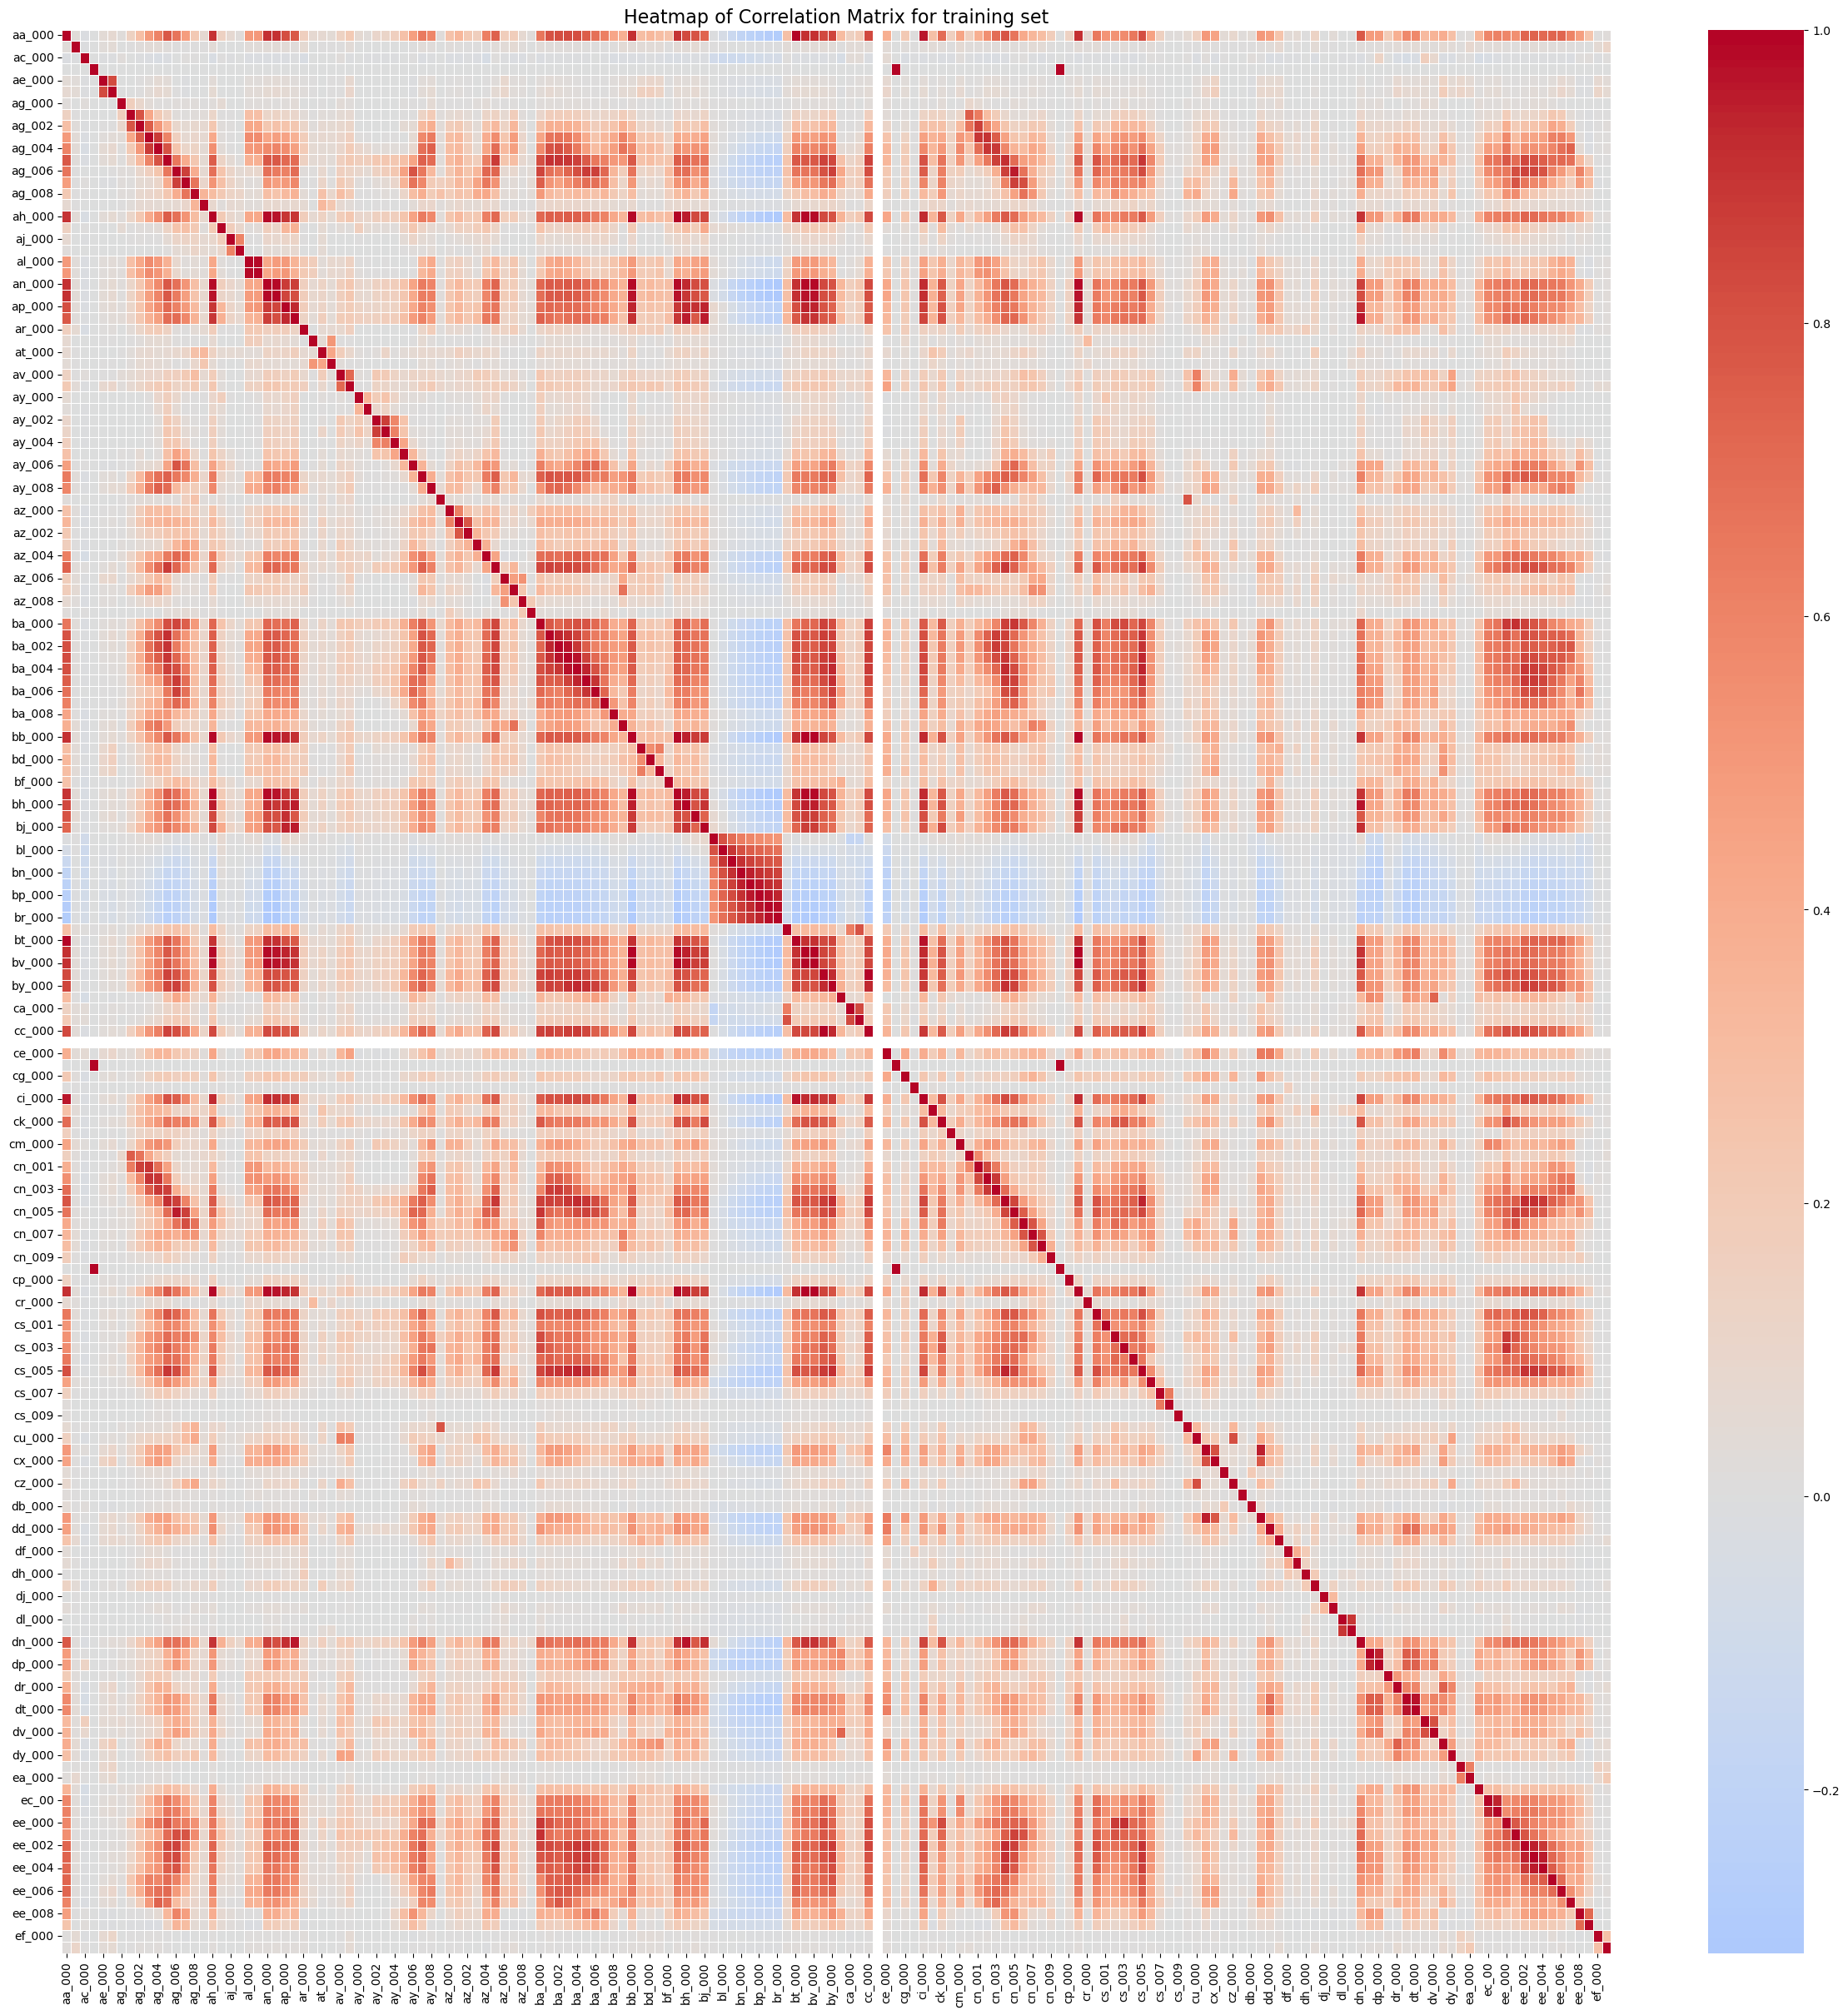

In [10]:
corr_matrix_train = X_train_imputed.corr()

print("Correlation Matrix for training set:")
print(corr_matrix_train)

plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix_train, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Heatmap of Correlation Matrix for training set", fontsize=16)
plt.show()

Correlation Matrix for test set:
          aa_000    ab_000    ac_000    ad_000    ae_000    af_000    ag_000  \
aa_000  1.000000  0.018828 -0.006724  0.089539  0.015277  0.017787  0.019822   
ab_000  0.018828  1.000000 -0.016177  0.042831 -0.001502  0.040105  0.000731   
ac_000 -0.006724 -0.016177  1.000000 -0.168208 -0.004065 -0.012440  0.002266   
ad_000  0.089539  0.042831 -0.168208  1.000000 -0.023999 -0.022514  0.021625   
ae_000  0.015277 -0.001502 -0.004065 -0.023999  1.000000  0.876924 -0.000833   
...          ...       ...       ...       ...       ...       ...       ...   
ee_007  0.240724  0.025320 -0.017340  0.145586  0.031275  0.026031  0.104794   
ee_008  0.140579 -0.000088  0.006265  0.130151 -0.008841 -0.011244  0.009129   
ee_009  0.067196 -0.001708  0.010266  0.061179 -0.008262 -0.009297 -0.000612   
ef_000  0.001176  0.016262 -0.006486  0.000932  0.015456  0.015408 -0.000248   
eg_000  0.000731  0.004555  0.020807 -0.005961  0.004222  0.005450 -0.000254   

      

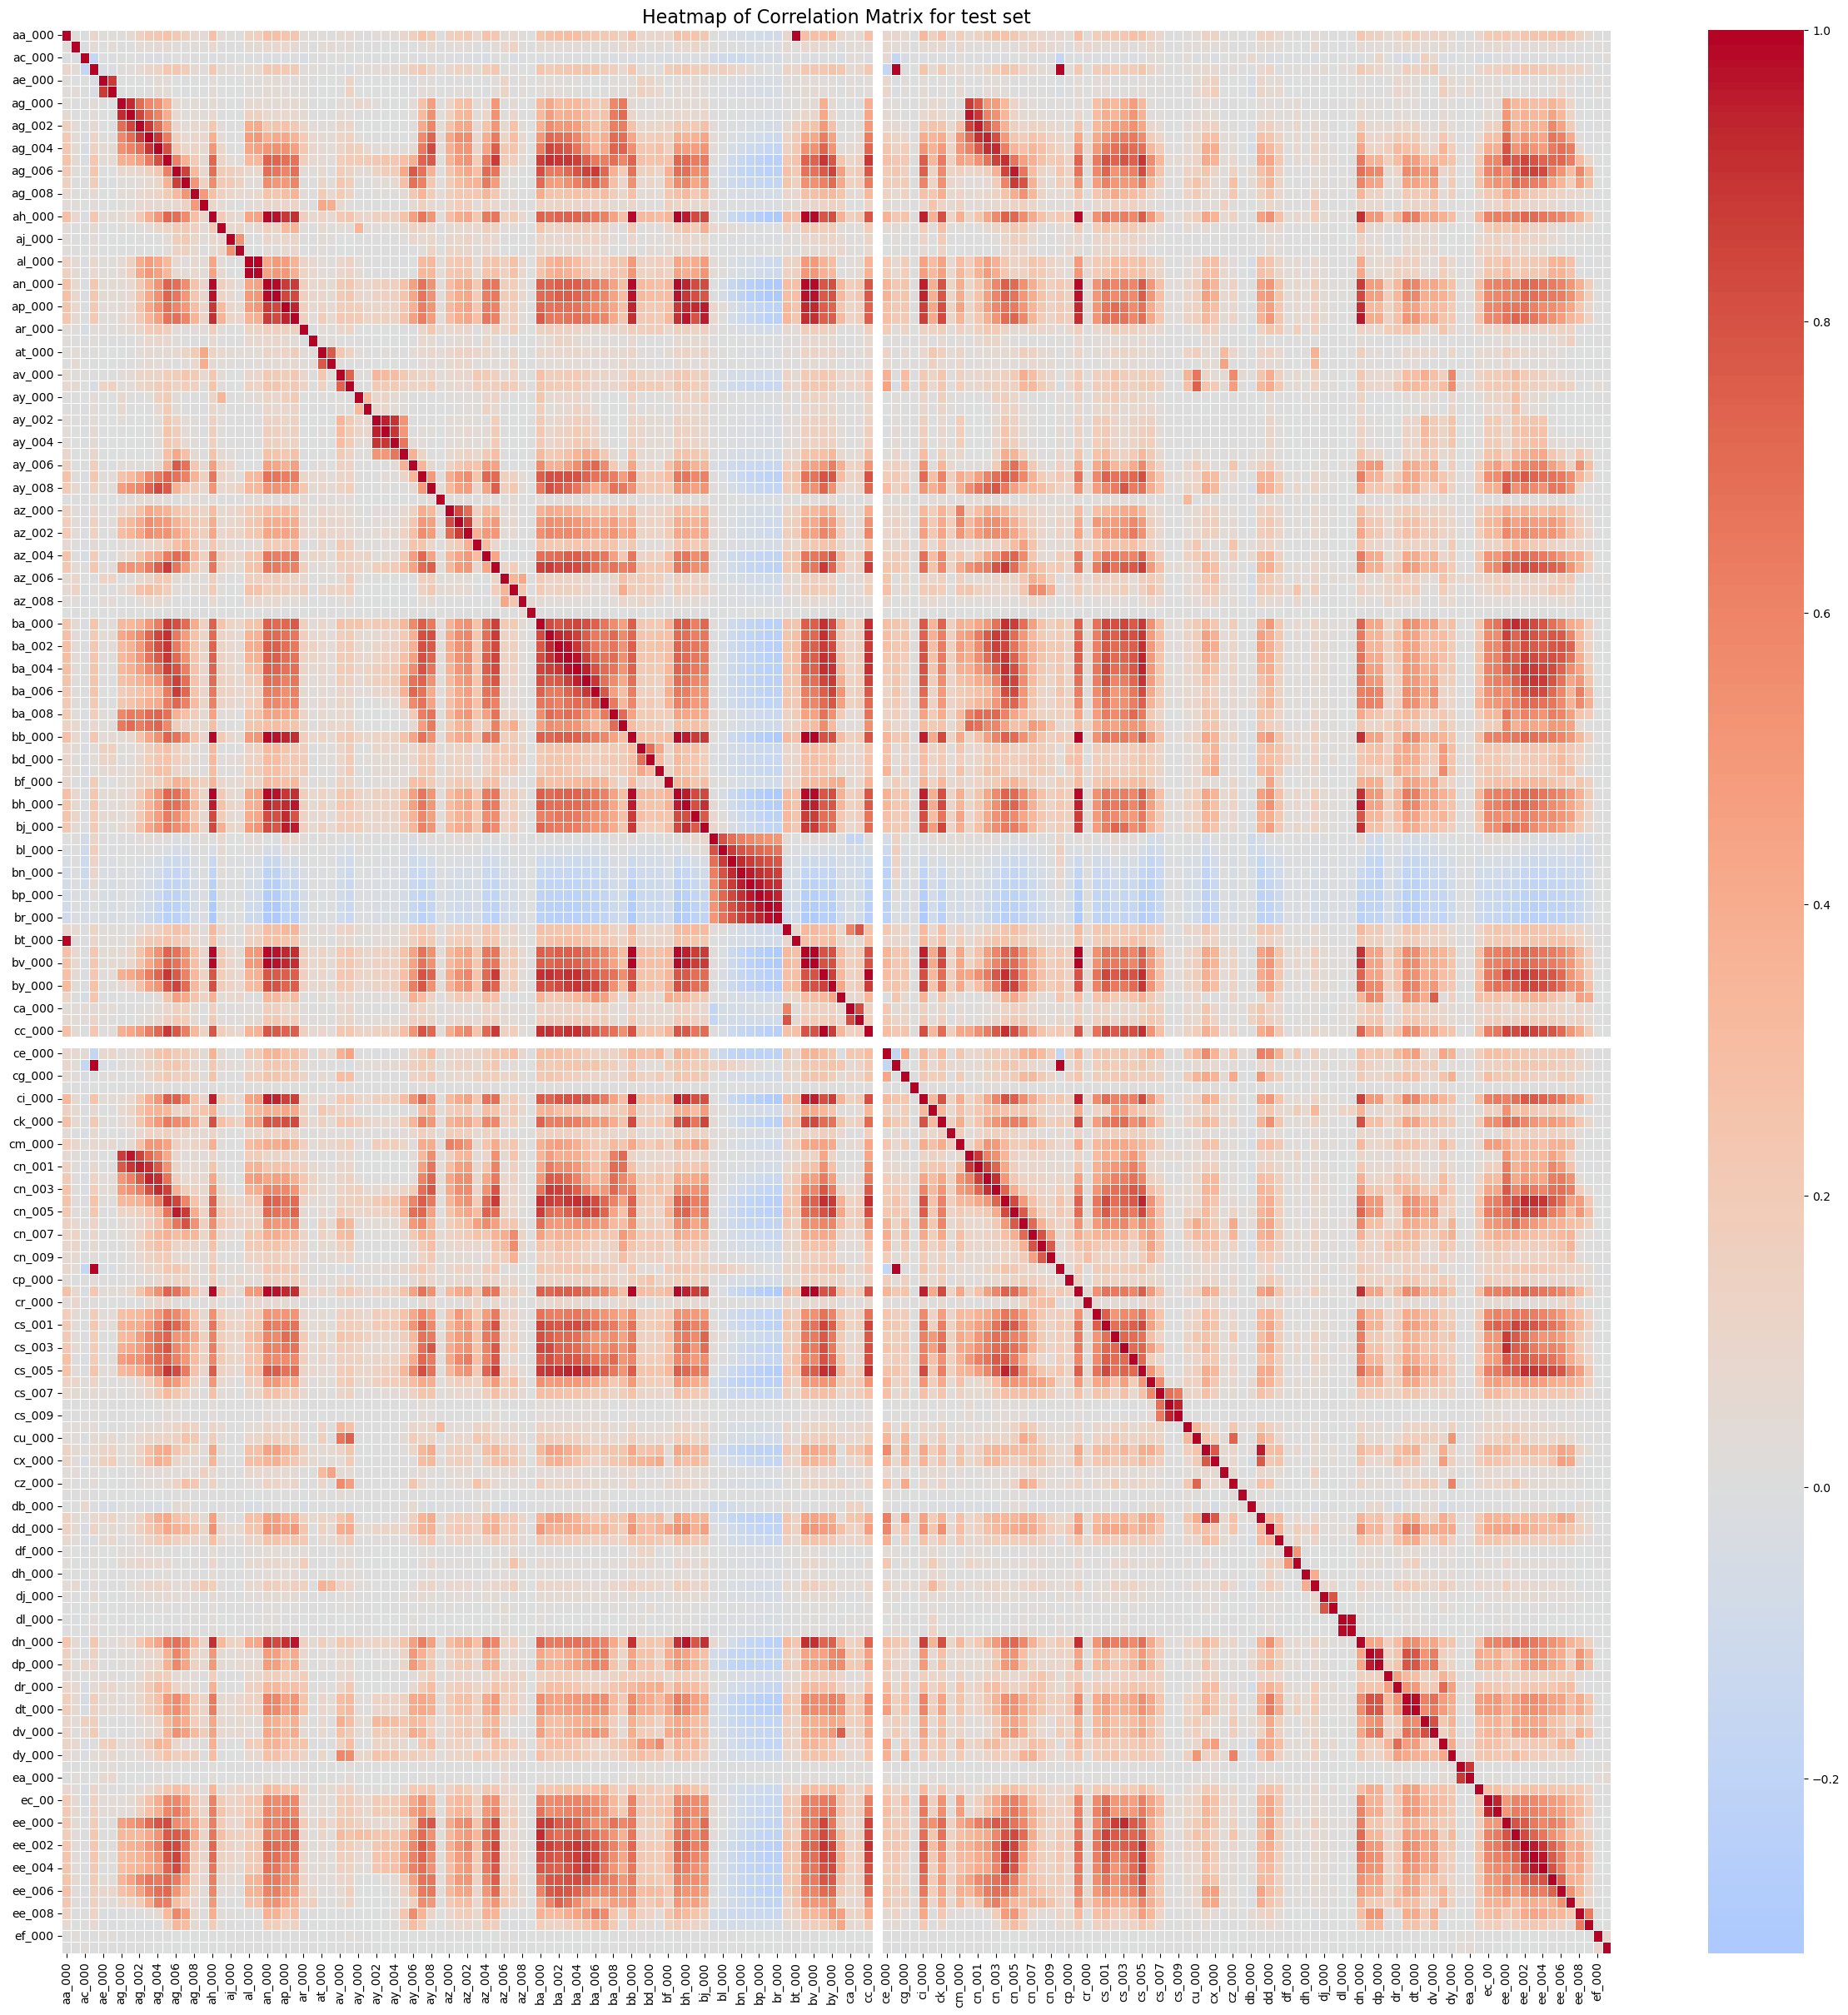

In [11]:
corr_matrix_test = X_test_imputed.corr()

print("Correlation Matrix for test set:")
print(corr_matrix_test)

plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix_test, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Heatmap of Correlation Matrix for test set", fontsize=16)
plt.show()

#### (iv) Make scatter plots and box plots

In [12]:
cv_sorted_train = cv_train.sort_values(ascending=False)

top_features_train = cv_sorted_train.head(int(np.floor(np.sqrt(170))))

print("Features with highest CV in training set:")
for feature, value in top_features_train.items():
    print(f"{feature}: {value}")

Features with highest CV in training set:
cs_009: 235.27760461028808
cf_000: 184.23309219117175
co_000: 183.94901745600419
ad_000: 183.84762036903822
dh_000: 114.98499085011493
dj_000: 109.64728493888241
ag_000: 91.87856462936655
as_000: 86.41690384051455
ay_009: 83.78606300858715
az_009: 76.96797806358812
ak_000: 74.52668795860689
au_000: 68.16055401269159
ch_000: 58.268228662299656


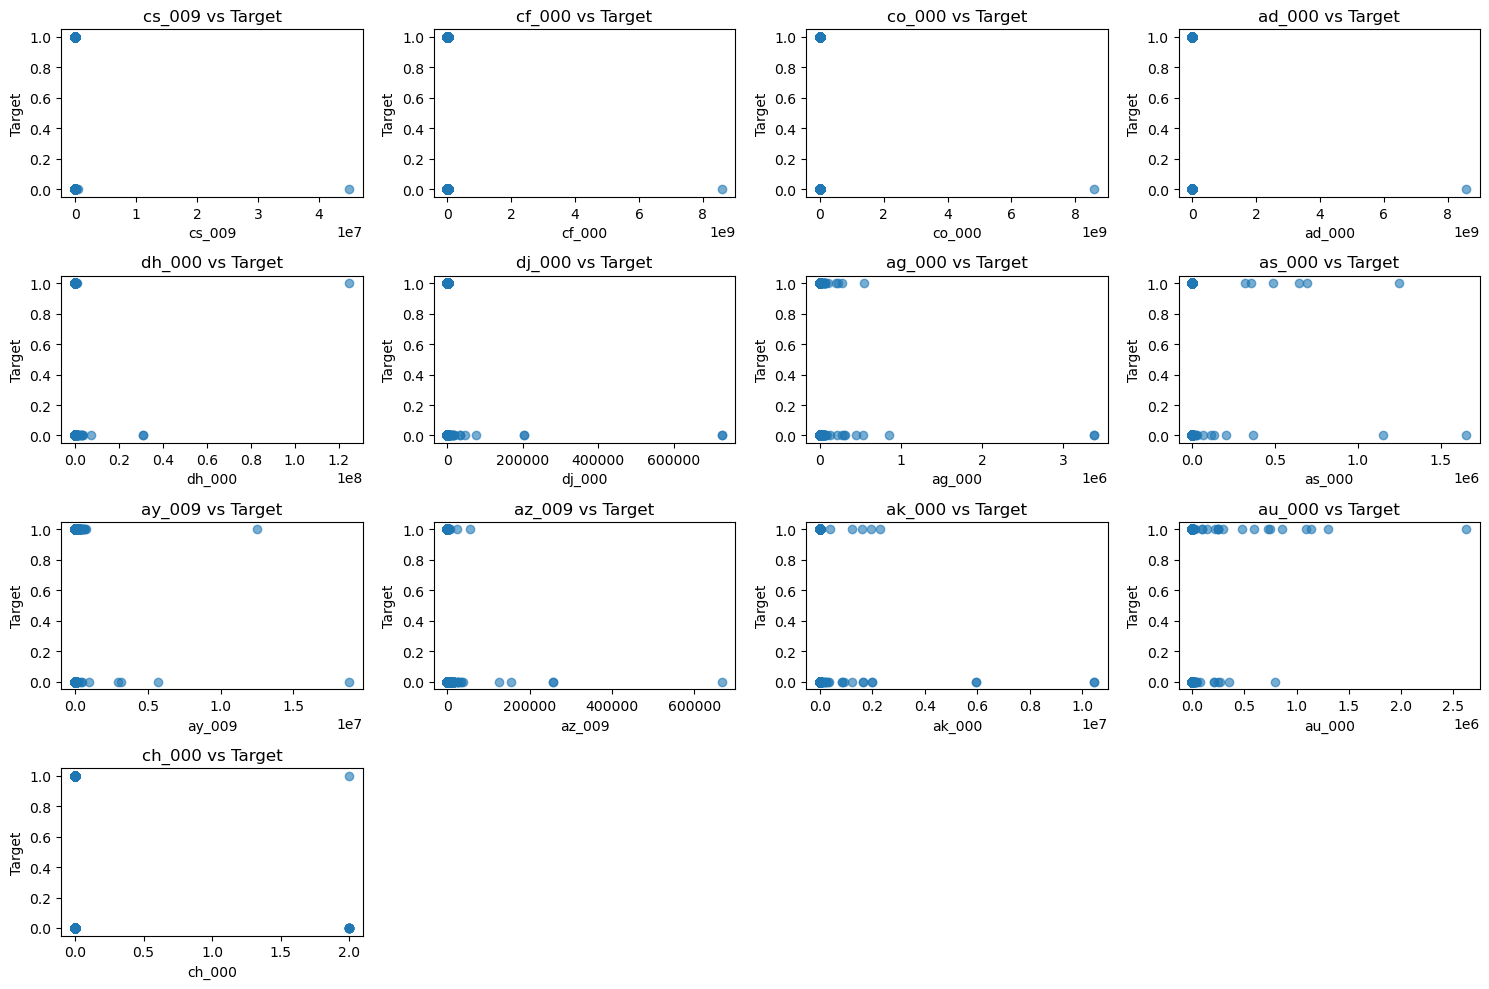

In [13]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features_train.index.tolist()):
    plt.subplot(4, 4, i+1)
    plt.scatter(X_train_imputed[feature], y_train, alpha=0.6)
    plt.xlabel(feature)
    plt.ylabel("Target")
    plt.title(f"{feature} vs Target")
plt.tight_layout()
plt.show()

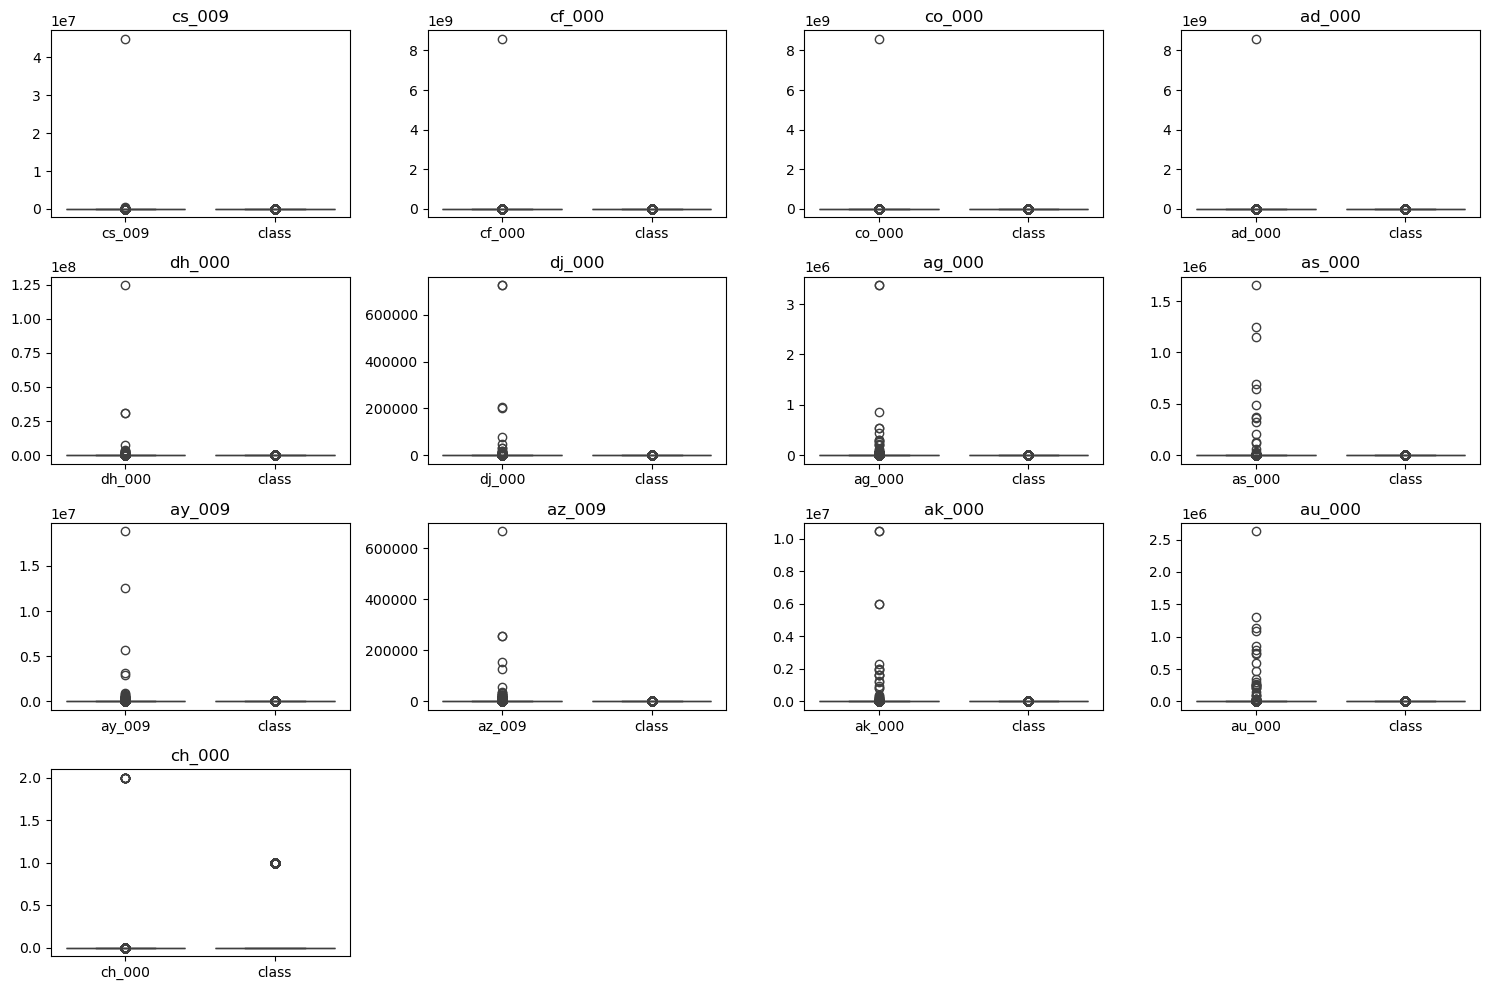

In [14]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features_train.index.tolist()):
    plt.subplot(4, 4, i+1)
    sns.boxplot((X_train_imputed[feature], y_train))
    plt.title(f"{feature}")
plt.tight_layout()
plt.show()

In [15]:
cv_sorted_test = cv_test.sort_values(ascending=False)

top_features_test = cv_sorted_test.head(int(np.floor(np.sqrt(170))))

print("Features with highest CV in test set:")
for feature, value in top_features_test.items():
    print(f"{feature}: {value}")

Features with highest CV in test set:
cs_009: 125.5472908312428
ak_000: 93.33608430249984
au_000: 85.04335924969436
as_000: 83.05589570005728
df_000: 77.43365436737167
cs_008: 62.85174754007061
az_009: 58.94997245581355
eg_000: 58.00203440605284
ch_000: 56.43273016716055
ag_000: 52.572601500355105
ef_000: 49.756393804435085
dz_000: 48.78932794112825
dh_000: 45.37761678675754


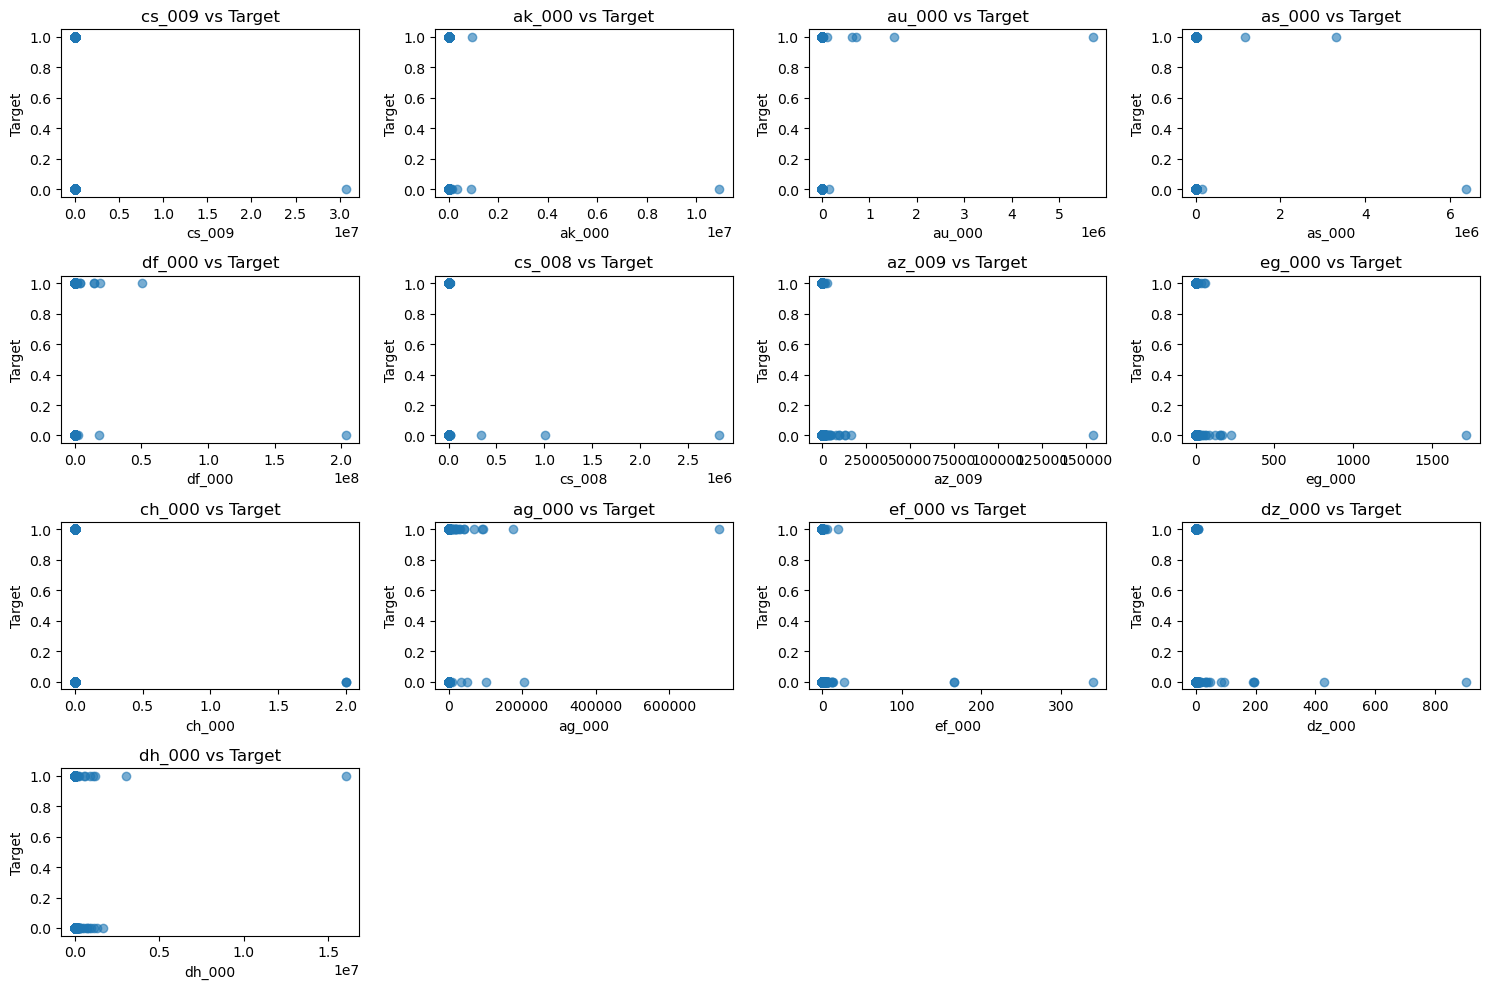

In [16]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features_test.index.tolist()):
    plt.subplot(4, 4, i+1)
    plt.scatter(X_test_imputed[feature], y_test, alpha=0.6)
    plt.xlabel(feature)
    plt.ylabel("Target")
    plt.title(f"{feature} vs Target")
plt.tight_layout()
plt.show()

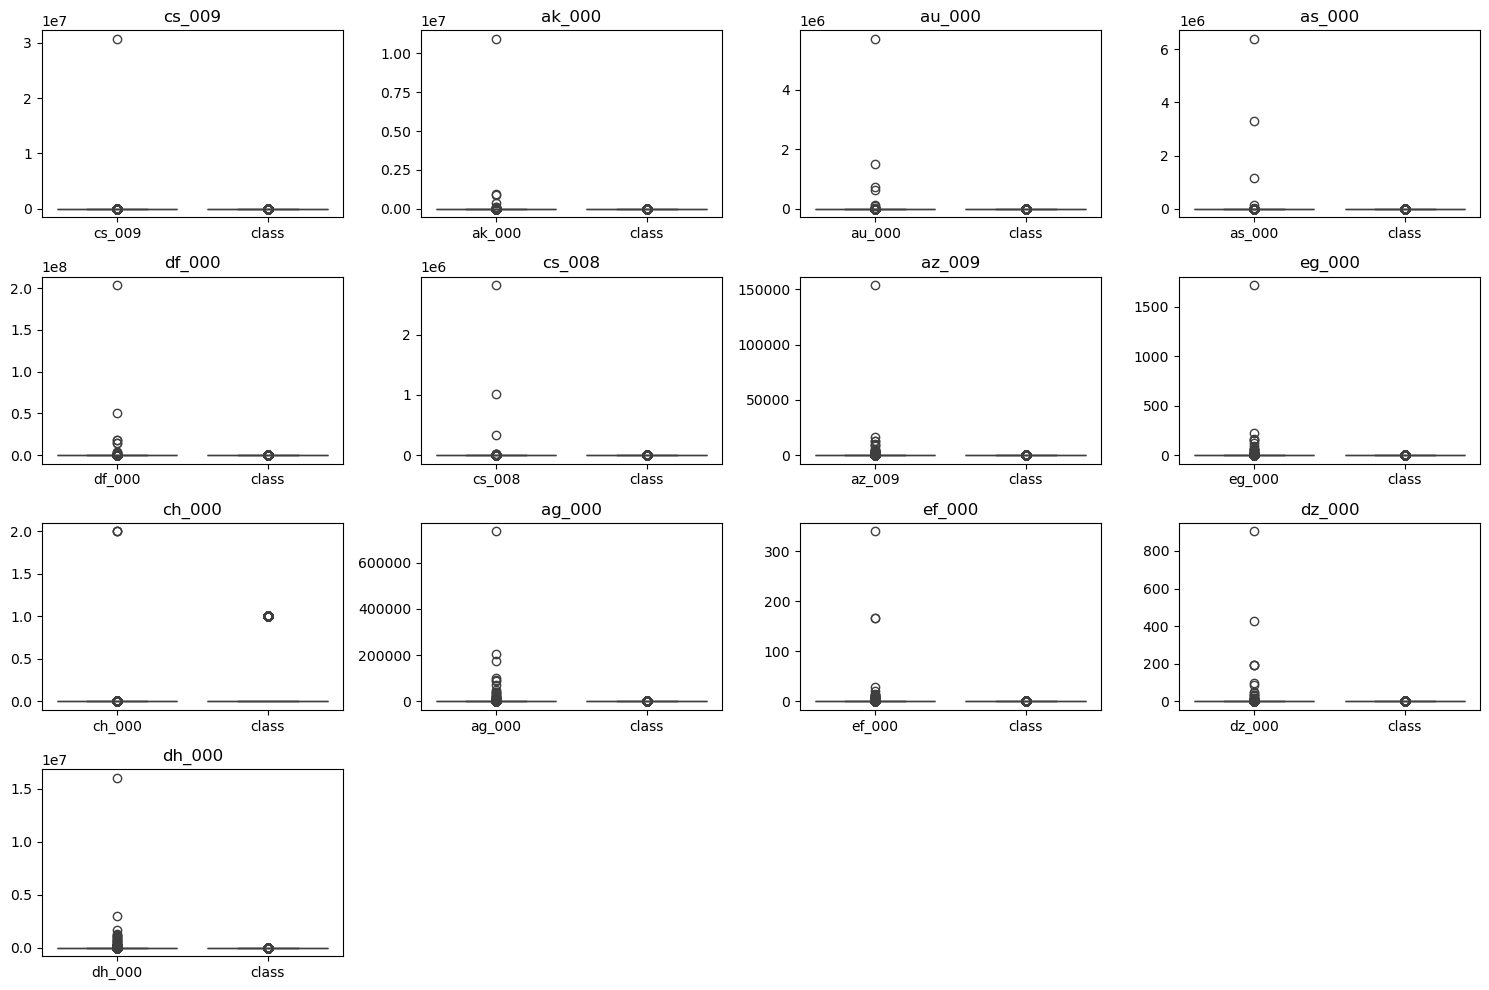

In [17]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features_test.index.tolist()):
    plt.subplot(4, 4, i+1)
    sns.boxplot((X_test_imputed[feature], y_test))
    plt.title(f"{feature}")
plt.tight_layout()
plt.show()

The scatterplots are unable to show proper relationship between the features as the data is dispersed. A scatterplot is anyways not really equipped to give an accurate answer about the significance of the feature as even if it shows some relationship of the independent feature with the dependent target variable, we have no way to know if that relationship is due to some random chance, or due to an interaction with another independent feature that is resulting in the relationship with the dependent variable, etc. In order to understand significance of a feature, more concrete methods would be required for example calculating p values of each feature by fitting the model on the data and checking which fall below the threshold, or finding interaction terms which can give an idea about the true nature of the feature, etc.

#### (v) Is this data set imbalanced?

In [18]:
positive_count_train = (y_train == 1).sum()
negative_count_train = (y_train == 0).sum()

print(f"Number of positive samples in training set: {positive_count_train}")
print(f"Number of negative samples in training set: {negative_count_train}")

total_train = len(y_train)
positive_ratio_train = positive_count_train / total_train
negative_ratio_train = negative_count_train / total_train

print(f"Positive ratio in training set: {positive_ratio_train}")
print(f"Negative ratio in training set: {negative_ratio_train}")

Number of positive samples in training set: 1000
Number of negative samples in training set: 59000
Positive ratio in training set: 0.016666666666666666
Negative ratio in training set: 0.9833333333333333


In [19]:
positive_count_test = (y_test == 1).sum()
negative_count_test = (y_test == 0).sum()

print(f"Number of positive samples in test set: {positive_count_test}")
print(f"Number of negative samples in test set: {negative_count_test}")

total_test = len(y_test)
positive_ratio_test = positive_count_test / total_test
negative_ratio_test = negative_count_test / total_test

print(f"Positive ratio in test set: {positive_ratio_test}")
print(f"Negative ratio in test set: {negative_ratio_test}")

Number of positive samples in test set: 375
Number of negative samples in test set: 15625
Positive ratio in test set: 0.0234375
Negative ratio in test set: 0.9765625


As it can be easily observed from the values printed, the negative class has 58000 more samples than the positive class in the training set with the possibility of the data point being from the negative class being 98.33%. Similarly, the negative class has 15250 more samples than the positive class in the test set with the possibility of the data point being from the negative class being 97.65%. It can be confidently concluded that the dataset is indeed highly imbalanced.

### (c) Train a random forest

In [20]:
rf = RandomForestClassifier(
    n_estimators=500,
    oob_score=True,
    random_state=42
)

rf.fit(X_train_imputed, y_train)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)

In [21]:
# Train predictions
y_train_pred_rf = rf.predict(X_train_imputed)
y_train_prob_rf = rf.predict_proba(X_train_imputed)[:, 1]

# Test predictions
y_test_pred_rf = rf.predict(X_test_imputed)
y_test_prob_rf = rf.predict_proba(X_test_imputed)[:, 1]

In [22]:
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
print("Train Confusion Matrix of the random forest:\n", cm_train_rf)

cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)
print("\n Test Confusion Matrix of the random forest:\n", cm_test_rf)

train_mcerr_rf = 1 - accuracy_score(y_train, y_train_pred_rf)
test_mcerr_rf = 1 - accuracy_score(y_test, y_test_pred_rf)

print(f"\nTraining Misclassification Error of the random forest: {train_mcerr_rf:.4f}")
print(f"\nTest Misclassification Error of the random forest: {test_mcerr_rf:.4f}")

# OOB error
oob_error_rf = 1 - rf.oob_score_
print(f"\nOut-of-Bag error estimate for the Random forest: {oob_error_rf:.4f}")

Train Confusion Matrix of the random forest:
 [[59000     0]
 [    0  1000]]

 Test Confusion Matrix of the random forest:
 [[15608    17]
 [  105   270]]

Training Misclassification Error of the random forest: 0.0000

Test Misclassification Error of the random forest: 0.0076

Out-of-Bag error estimate for the Random forest: 0.0058


Since no balancing technique was applied to this random forest, the small difference between the OOB error (0.0058) and the test error (0.0076) likely reflects that the model fits the majority class (negative) very well but struggles to understand the minority (positive) class. This iindicates low variance and good generalization, but the underlying class imbalance likely introduces bias toward the majority class, causing the model to underperform on minority instances, meaning misclassifications of the minority cases have little impact on the total error. This imbalance can therefore mislead into thinking that the model is actually performing well, even though the model performs poorly in identifying the minority cases.

Train AUC score of Random forest: 1.0
Test AUC score of Random forest: 0.99550336


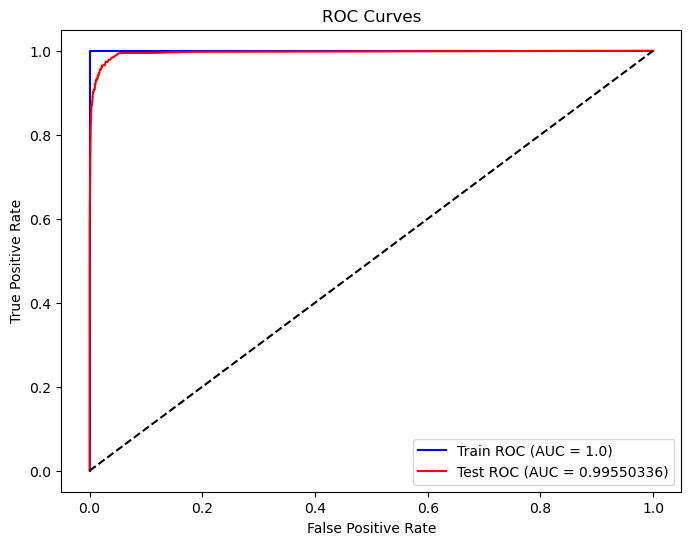

In [23]:
# Train ROC and AUC
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_prob_rf)
roc_auc_train_rf = auc(fpr_train_rf, tpr_train_rf)

# Test ROC and AUC
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_prob_rf)
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

print(f"Train AUC score of Random forest: {roc_auc_train_rf}")
print(f"Test AUC score of Random forest: {roc_auc_test_rf}")

plt.figure(figsize=(8,6))
plt.plot(fpr_train_rf, tpr_train_rf, color='blue', label=f'Train ROC (AUC = {roc_auc_train_rf})')
plt.plot(fpr_test_rf, tpr_test_rf, color='red', label=f'Test ROC (AUC = {roc_auc_test_rf})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


### (d) Research class imbalance in random forest

1. Class Weights or Cost-Sensitive: 
Give more weight to the minority class and less weight to the majority class. This will cause the learning algorithm to focus more on the minority class, since the penalty for the minority class to be misclassified is greater. You can specify the class_weight parameter to be 'balanced' or specify the weights manually in libraries such as scikit-learn.

2. Data Resampling (Balanced Random Forest):
The data will be resampled so that each bootstrap sample, used to build a tree, has an equal number of cases from each class. This will mean undersampling the majority class to match the number of examples in the minority class, to increase the trees’ sensitivity to the rare class.

3. Ensemble Methods:
Employ 'bags of trees' learned on resampled, balanced datasets or weighted outputs to leverage the strengths of different models in dealing with the rare class effectively

4. Synthetic Minority Oversampling Technique:
SMOTE is an oversampling technique that can be used to solve the problem of class imbalance by creating artificial examples of the minority class. Rather than simply creating copies of the existing minority class examples, SMOTE creates artificial examples by computing the line between each minority class example and one of its nearest neighbors in the feature space, thereby allowing the minority class to be oversampled with artificial examples that have diverse characteristics, hence creating greater balance in the data set, which can help improve the performance of the classifier.

5. Threshold Adjustment:
After training, the probability threshold can be lowered for the minority class to improve recall. This doesn’t retrain the model but fine-tunes predictions to favor the rare class.

In [24]:
rf_balanced = RandomForestClassifier(
    n_estimators=500,
    oob_score=True,
    random_state=42,
    class_weight='balanced'
)

rf_balanced.fit(X_train_imputed, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       oob_score=True, random_state=42)

In [25]:
# Train predictions
y_train_pred_rf_bal = rf_balanced.predict(X_train_imputed)
y_train_prob_rf_bal = rf_balanced.predict_proba(X_train_imputed)[:, 1]

# Test predictions
y_test_pred_rf_bal = rf_balanced.predict(X_test_imputed)
y_test_prob_rf_bal = rf_balanced.predict_proba(X_test_imputed)[:, 1]


In [26]:
cm_train_rf_bal = confusion_matrix(y_train, y_train_pred_rf_bal)
cm_test_rf_bal = confusion_matrix(y_test, y_test_pred_rf_bal)

print("Train Confusion Matrix of the class-balanced random forest:\n", cm_train_rf_bal)
print("Test Confusion Matrix of the class-balanced random forest:\n", cm_test_rf_bal)

train_misclass_rf_bal = 1 - accuracy_score(y_train, y_train_pred_rf_bal)
test_misclass_rf_bal = 1 - accuracy_score(y_test, y_test_pred_rf_bal)

print(f"Training Misclassification Error of the class-balanced random forest: {train_misclass_rf_bal}")
print(f"Test Misclassification Error of the class-balanced random forest: {test_misclass_rf_bal}")

# OOB error
oob_error_balanced = 1 - rf_balanced.oob_score_
print(f"Out-of-Bag error estimate for the class-balanced Random forest: {oob_error_balanced}")

Train Confusion Matrix of the class-balanced random forest:
 [[59000     0]
 [    0  1000]]
Test Confusion Matrix of the class-balanced random forest:
 [[15614    11]
 [  157   218]]
Training Misclassification Error of the class-balanced random forest: 0.0
Test Misclassification Error of the class-balanced random forest: 0.010499999999999954
Out-of-Bag error estimate for the class-balanced Random forest: 0.007516666666666616


Train AUC score of the class-balanced Random forest: 1.0
Test AUC score of the class-balanced Random forest: 0.9932348586666666


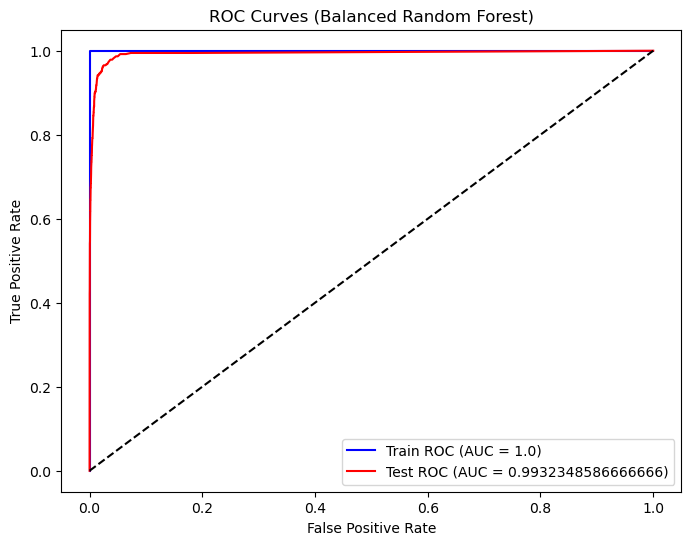

In [27]:
# Train ROC and AUC
fpr_train_rf_bal, tpr_train_rf_bal, _ = roc_curve(y_train, y_train_prob_rf_bal)
roc_auc_train_rf_bal = auc(fpr_train_rf_bal, tpr_train_rf_bal)

# Test ROC and AUC
fpr_test_rf_bal, tpr_test_rf_bal, _ = roc_curve(y_test, y_test_prob_rf_bal)
roc_auc_test_rf_bal = auc(fpr_test_rf_bal, tpr_test_rf_bal)

print(f"Train AUC score of the class-balanced Random forest: {roc_auc_train_rf_bal}")
print(f"Test AUC score of the class-balanced Random forest: {roc_auc_test_rf_bal}")

plt.figure(figsize=(8,6))
plt.plot(fpr_train_rf_bal, tpr_train_rf_bal, color='blue', label=f'Train ROC (AUC = {roc_auc_train_rf_bal})')
plt.plot(fpr_test_rf_bal, tpr_test_rf_bal, color='red', label=f'Test ROC (AUC = {roc_auc_test_rf_bal})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Balanced Random Forest)')
plt.legend()
plt.show()

After applying the technique for the class imbalance, there was a subtle but significant shift in the Random Forest’s performance. In the unbalanced model, the test error rate was 0.0076, with an AUC of 0.9955, which was highly accurate but highly biased toward the majority class. When class imbalance correction was added to the same random forest model, the test error rate was slightly higher, at 0.0105, with a lower AUC of 0.9932. The slight reduction in the accuracy is due to the fact that the balanced model was less sure about the majority class prediction, increasing variance but sensitivity to the other class, which was observed by the improved detection of the minority class in the confusion table from 270 to 218 instances.

Although there was only a slight change in the total testing accuracy, the balanced model is fairer in its treatment of the two classes, with less emphasis on the majority class as compared to the unbalanced model. The Out-of-Bag error also slightly improves, from 0.0058 to 0.0075, reflecting the slight increase in variance observed. Thus, the class balancing method has only slight benefits on improving the accuracy but made it more trustworthy, particularly in detecting the minority class for the APS dataset which has significant imbalances between the two classes as observed in the previous section.

### (e) XGBoost and Model Trees

In [28]:
xgb_model = xgb.XGBClassifier(
    booster='gblinear',
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

param_grid_xgb = {'reg_alpha': [0, 0.01, 0.1, 1, 10]}  

cv_xgb = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid_xgb, scoring='accuracy', cv=cv_xgb, return_train_score=True)
grid_search.fit(X_train_imputed, y_train)

print("Cross-validation results for each alpha:")
for mean_score, alpha in zip(grid_search.cv_results_['mean_test_score'],grid_search.cv_results_['param_reg_alpha']):
    print(f"Alpha: {alpha}, Mean CV Accuracy: {mean_score}")

print("\nBest alpha based on CV for the xgboost tree:", grid_search.best_params_['reg_alpha'])

Cross-validation results for each alpha:
Alpha: 0.0, Mean CV Accuracy: 0.98715
Alpha: 0.01, Mean CV Accuracy: 0.9888
Alpha: 0.1, Mean CV Accuracy: 0.9886666666666667
Alpha: 1.0, Mean CV Accuracy: 0.9887833333333335
Alpha: 10.0, Mean CV Accuracy: 0.9863833333333334

Best alpha based on CV for the xgboost tree: 0.01


In [29]:
best_model_xgb = grid_search.best_estimator_
best_model_xgb.fit(X_train_imputed, y_train)

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [30]:
# Train
y_train_pred_xgb = best_model_xgb.predict(X_train_imputed)
y_train_prob_xgb = best_model_xgb.predict_proba(X_train_imputed)[:, 1]

# Test
y_test_pred_xgb = best_model_xgb.predict(X_test_imputed)
y_test_prob_xgb = best_model_xgb.predict_proba(X_test_imputed)[:, 1]

cm_train_xgb = confusion_matrix(y_train, y_train_pred_xgb)
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)

print("Train Confusion Matrix for the XGBoost model:\n", cm_train_xgb)
print("Test Confusion Matrix for the XGboost model:\n", cm_test_xgb)

train_mcer_xgb = 1 - accuracy_score(y_train, y_train_pred_xgb)
test_mcer_xgb = 1 - accuracy_score(y_test, y_test_pred_xgb)

print(f"Training Misclassification Error for the xgboost model: {train_mcer_xgb}")
print(f"Test Misclassification Error for the xgboost model: {test_mcer_xgb}")


print(f"Best CV Accuracy for the xgboost model: {grid_search.best_score_}")
print(f"Test Accuracy for the xgboost model: {accuracy_score(y_test, y_test_pred_xgb)}")

Train Confusion Matrix for the XGBoost model:
 [[58405   595]
 [  184   816]]
Test Confusion Matrix for the XGboost model:
 [[15457   168]
 [   60   315]]
Training Misclassification Error for the xgboost model: 0.012983333333333347
Test Misclassification Error for the xgboost model: 0.014249999999999985
Best CV Accuracy for the xgboost model: 0.9888
Test Accuracy for the xgboost model: 0.98575


The cross-validation accuracy of 0.9888 and test accuracy of 0.98575 for the XGBoost model show good consistency. This suggests that the model has captured the data distribution well without overfitting. The small difference between the cross-validation and test performance means the cross-validation estimate is a fair and dependable indicator of generalization error. This shows that the model has low variance (solid performance across folds and test data) and low bias (sufficient complexity to capture important patterns from train data). Overall, the XGBoost model has strong generalization performance and reliability across different data splits.

Train AUC score of the Xgboost model: 0.9029576271186439
Test AUC score of the Xgboost model: 0.914624


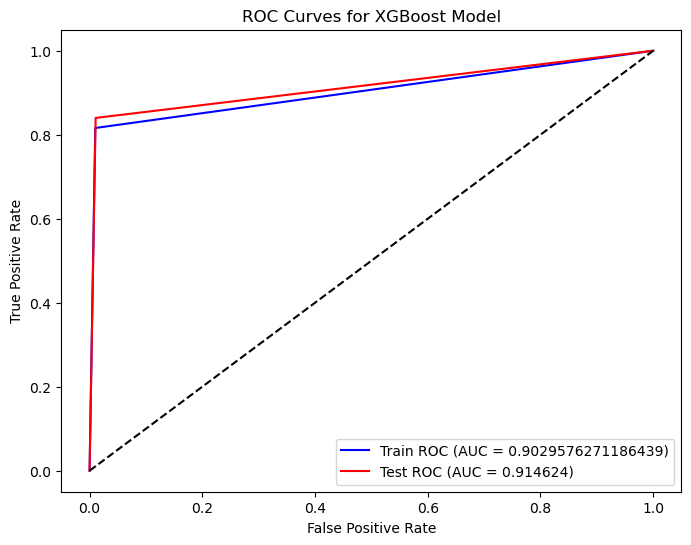

In [31]:
# Train ROC
fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train, y_train_prob_xgb)
roc_auc_train_xgb = auc(fpr_train_xgb, tpr_train_xgb)

# Test ROC
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_test_prob_xgb)
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

print(f"Train AUC score of the Xgboost model: {roc_auc_train_xgb}")
print(f"Test AUC score of the Xgboost model: {roc_auc_test_xgb}")

plt.figure(figsize=(8,6))
plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', label=f'Train ROC (AUC = {roc_auc_train_xgb})')
plt.plot(fpr_test_xgb, tpr_test_xgb, color='red', label=f'Test ROC (AUC = {roc_auc_test_xgb})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost Model')
plt.legend()
plt.show()

### (f) Use SMOTE to pre-process your data

In [32]:
smote = SMOTE(random_state=42)
xgb_sm = xgb.XGBClassifier(
    booster='gblinear',
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

pipe = ImbPipeline(steps=[('smote', smote), ('xgb', xgb_sm)])

param_grid_pipe = {'xgb__reg_alpha': [0, 0.01, 0.1, 1, 10]}
cv_sm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_smote = GridSearchCV(pipe, param_grid_pipe, scoring='accuracy', cv=cv_sm)
grid_smote.fit(X_train_imputed, y_train)

print("Cross-validation results for each alpha:")
for mean_score, alpha in zip(grid_smote.cv_results_['mean_test_score'], grid_smote.cv_results_['param_xgb__reg_alpha']):
    print(f"Alpha: {alpha}, Mean CV Accuracy: {mean_score}")

print("\nBest alpha based on CV for the xgboost tree after applying SMOTE:", grid_smote.best_params_['xgb__reg_alpha'])

Cross-validation results for each alpha:
Alpha: 0.0, Mean CV Accuracy: 0.9385333333333333
Alpha: 0.01, Mean CV Accuracy: 0.9791333333333334
Alpha: 0.1, Mean CV Accuracy: 0.9772000000000001
Alpha: 1.0, Mean CV Accuracy: 0.9680833333333332
Alpha: 10.0, Mean CV Accuracy: 0.9445666666666668

Best alpha based on CV for the xgboost tree after applying SMOTE: 0.01


In [33]:
best_smote_model = grid_smote.best_estimator_
best_smote_model.fit(X_train_imputed, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster='gblinear',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [34]:
# Train predictions
y_train_pred_sm = best_smote_model.predict(X_train_imputed)
y_train_prob_sm = best_smote_model.predict_proba(X_train_imputed)[:, 1]

# Test predictions (no resampling applied to test)
y_test_pred_sm = best_smote_model.predict(X_test_imputed)
y_test_prob_sm = best_smote_model.predict_proba(X_test_imputed)[:, 1]

Train Confusion Matrix (SMOTE):
 [[57036  1964]
 [   70   930]]

Test Confusion Matrix (SMOTE):
 [[15110   515]
 [   28   347]]

Training Misclassification Error (SMOTE): 0.03390000000000004
Test Misclassification Error (SMOTE): 0.033937499999999954
Test Accuracy (SMOTE): 0.9660625

Training AUC (SMOTE): 0.94835593220339
Test AUC (SMOTE): 0.9461866666666667


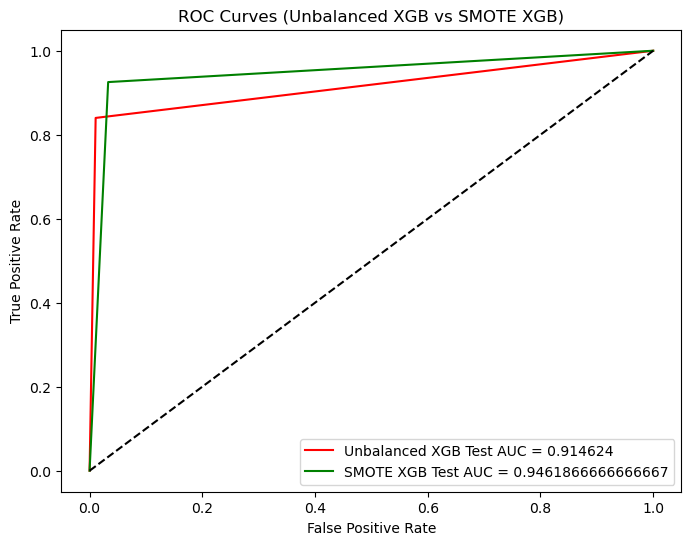

In [41]:
cm_train_sm = confusion_matrix(y_train, y_train_pred_sm)
cm_test_sm = confusion_matrix(y_test, y_test_pred_sm)
print("Train Confusion Matrix (SMOTE):\n", cm_train_sm)
print("\nTest Confusion Matrix (SMOTE):\n", cm_test_sm)

# Misclassification errors
train_mis_sm = 1 - accuracy_score(y_train, y_train_pred_sm)
test_mis_sm = 1 - accuracy_score(y_test, y_test_pred_sm)
test_acc_sm = accuracy_score(y_test, y_test_pred_sm)
print(f"\nTraining Misclassification Error (SMOTE): {train_mis_sm}")
print(f"Test Misclassification Error (SMOTE): {test_mis_sm}")
print(f"Test Accuracy (SMOTE): {test_acc_sm}")

# ROC + AUC
fpr_train_sm, tpr_train_sm, _ = roc_curve(y_train, y_train_prob_sm)
roc_auc_train_sm = auc(fpr_train_sm, tpr_train_sm)

fpr_test_sm, tpr_test_sm, _ = roc_curve(y_test, y_test_prob_sm)
roc_auc_test_sm = auc(fpr_test_sm, tpr_test_sm)

print(f"\nTraining AUC (SMOTE): {roc_auc_train_sm}")
print(f"Test AUC (SMOTE): {roc_auc_test_sm}")

plt.figure(figsize=(8,6))
plt.plot(fpr_test_xgb, tpr_test_xgb, color='red', label=f'Unbalanced XGB Test AUC = {roc_auc_test_xgb}')
plt.plot(fpr_test_sm, tpr_test_sm, color='green', label=f'SMOTE XGB Test AUC = {roc_auc_test_sm}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Unbalanced XGB vs SMOTE XGB)')
plt.legend()
plt.show()

The SMOTE-augmented XGBoost model achieved a cross-validation accuracy of 0.9791 and a test accuracy of 0.966. This shows strong generalization performance, with only a slight drop from training to test results. The training and test AUC values, 0.9483 and 0.9461, indicate excellent class separability. This confirms that the model learned to effectively distinguish between the minority and majority classes. The small rise in misclassification error, compared to the non-SMOTE case, explains the added variability from synthetic oversampling but suggests improved balance. Overall, the SMOTE-based XGBoost model offers a good trade-off between bias and variance. It handles minority class instances better while keeping high predictive performance and stability across folds.

*Comparison between unbalanced XGB and SMOTE XGB*:

Applying SMOTE to the XGBoost model led to a noticeable improvement in test AUC (from ~0.9146 to ~0.9461), indicating a much better ability to distinguish between classes; particularly the minority class. However, this increase in class sensitivity led to an increase in misclassification error (from ~0.0142 to ~0.033) and a drop in CV accuracy, an indication of some added variance due to oversampling. The uncompensated model performed slightly better in overall accuracy but was biased toward the majority class, while the SMOTE-balanced model achieved a more unbiased, equal classification performance across both classes. Overall, SMOTE improved the model’s robustness in handling imbalance at the cost of a slight increase in error and complexity.

## 2. ISLR 6.6.3

As we increase s from 0:

    a) iv. Steadily decrease.
    At s=0, the penalty is strongest, as all coefficients are shrunk to 0, meaning that the model will just predict mean of y. As s will increase, the penalty becomes less harsher, reducing bias and resulting in the model becoming more flexible as more number of coefficients will start begin taking non-zero values with larger magnitudes, thus allowing it to fit more to the training data by fitting the more complex patterns and reducing the overall training RSS.

    b) ii. Decrease initially, and then eventually start increasing in a U shape.
    As s increases, the model will become more flexible by allowing coefficients to take nonzero values and larger magnitudes. Initially, this reduces bias and improves test predictions, so the test RSS decreases. However, beyond a certain value of s, increasing it would make the model overly flexible, leading to it fitting even the noise in the training data. This will increase the variance and cause the test RSS to rise. Thus, test RSS follows a U-shaped pattern as s increases.

    c) iii. Steadily increases.
    As s increases, the model becomes more flexible because now coefficients can take on larger values, and more features can contribute to the prediction. With this increased flexibility, the model could fit the training data very closely, including any random noise. Therefore, small changes in the training data (either by using different samples or random noise) could result in larger changes in the coefficients and predictions, thus increasing its variance.

    d) iv. Steadily decreases
    High bias occurs due to underfitting since the model is consistently missing the true relationships between the predictors and the response. As s increases, the constraint on the coefficient estimates becomes weaker, and they can move towards their true coefficients and fit more of the underlying relationship. Consequently, the squared bias monotonically decreases in s.

    e) v. Remains constant
    The irreducible error describes the variability in the response variable y that cannot be explained by any model. This could be due to the presence of random noise, unobserved factors, or uncontrolled factors. This element of error is not related to the model, coefficients, or choice of s. Thus, no matter how large s gets, the irreducible error remains unchanged.

## 3. ISLR 6.6.5

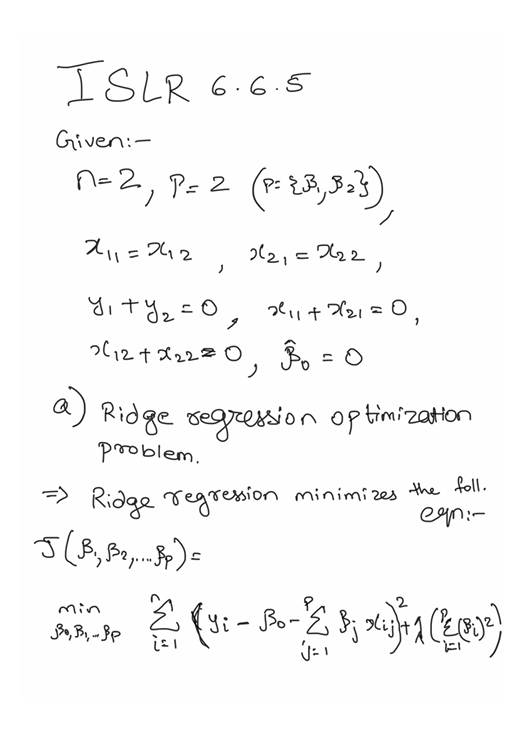
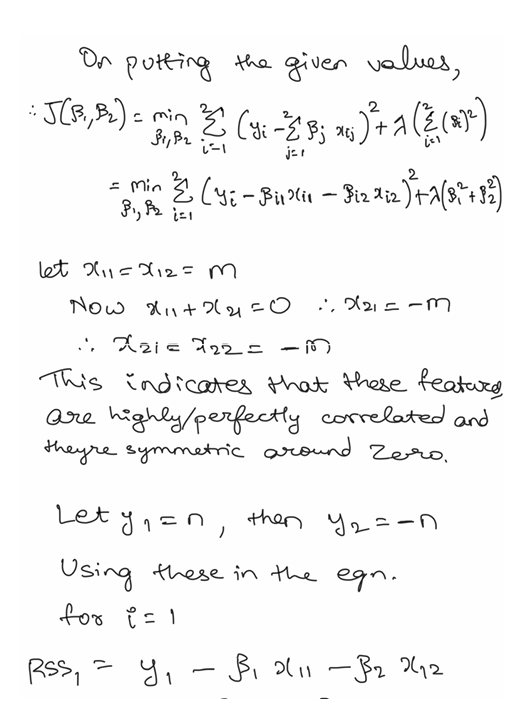
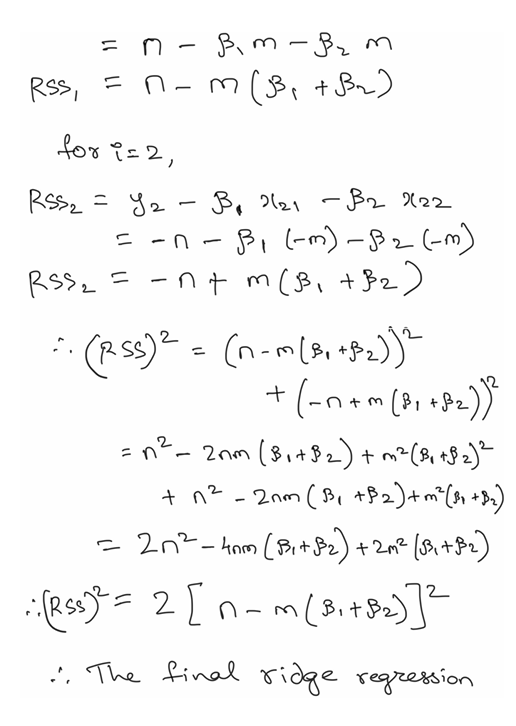
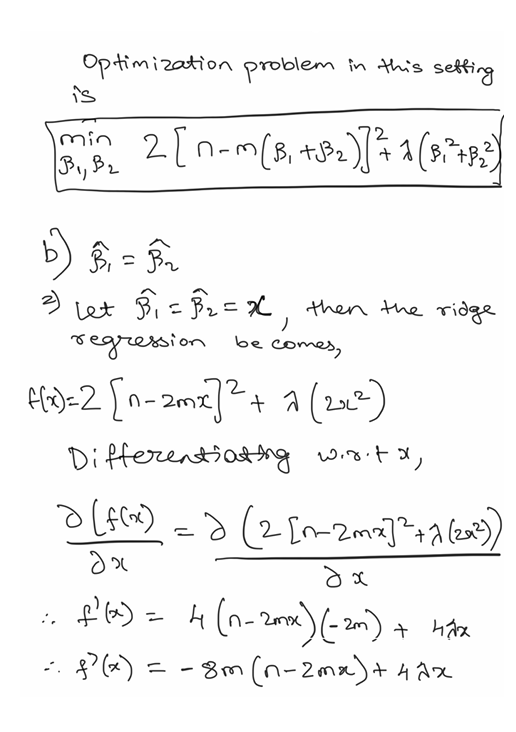
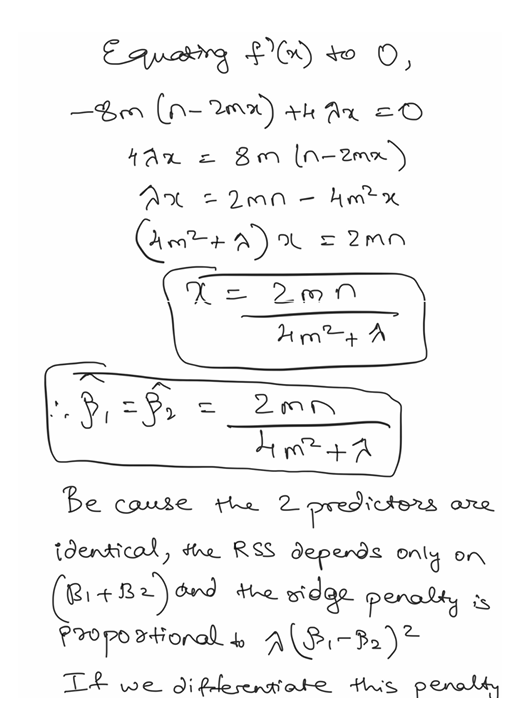
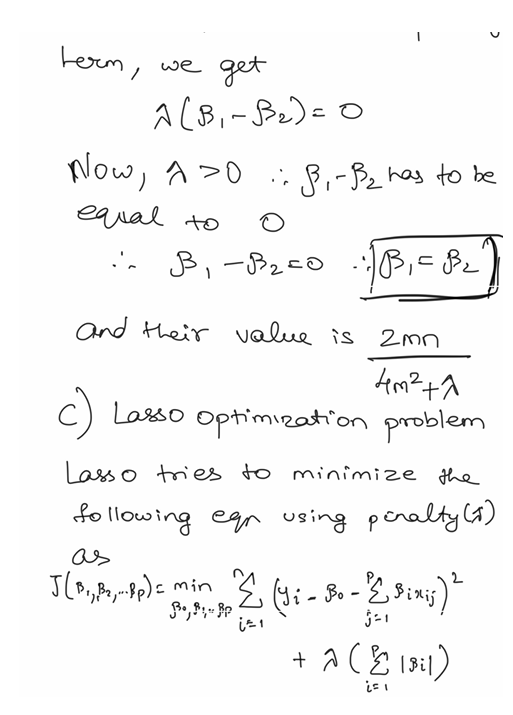
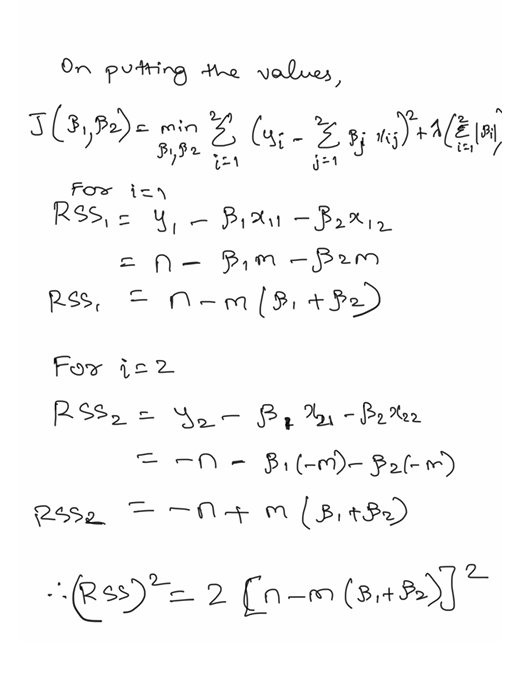
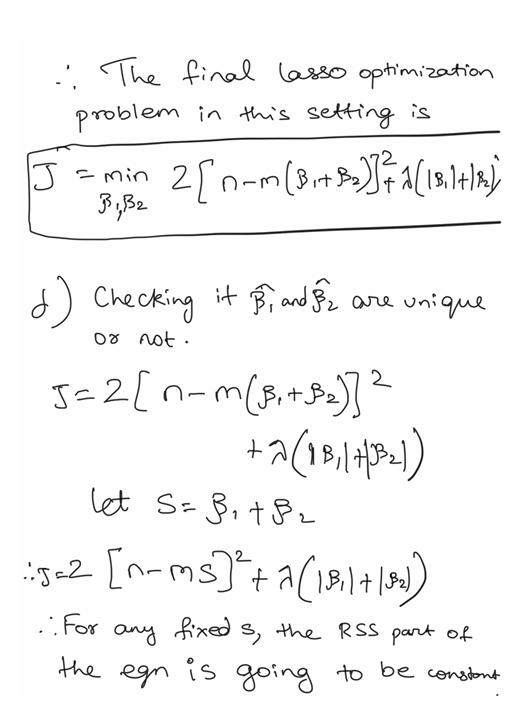
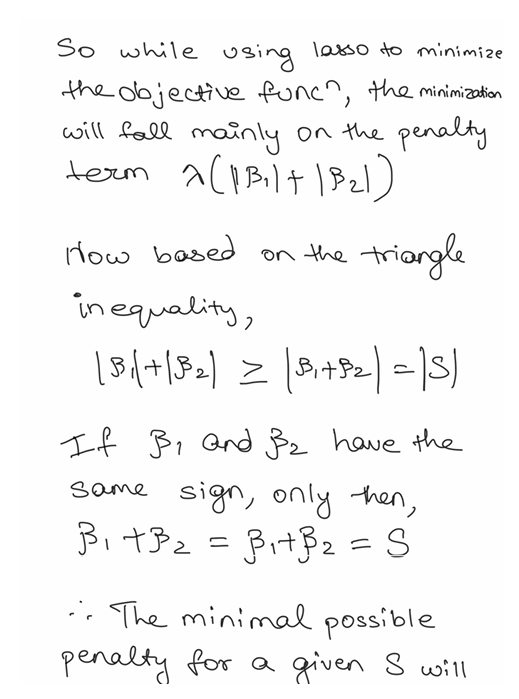
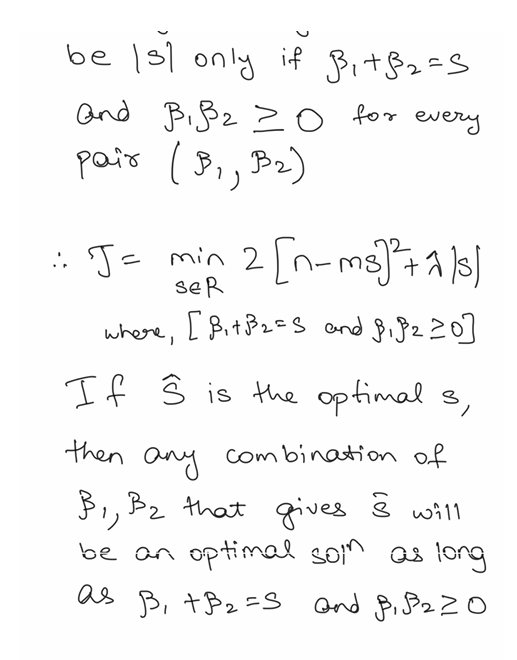
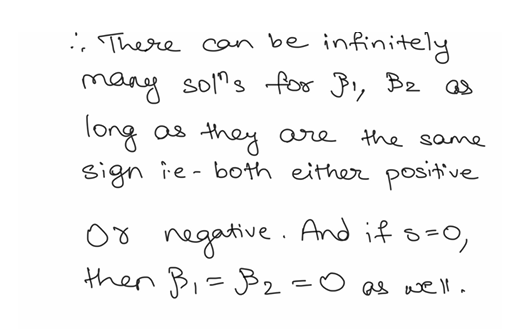

## 4. ISLR 8.4.5

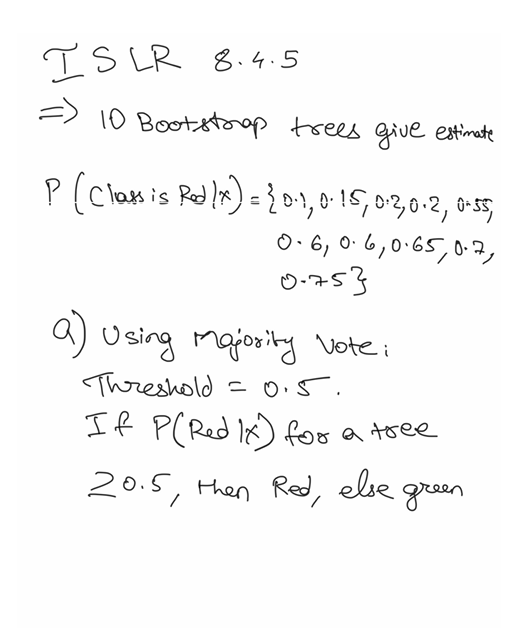
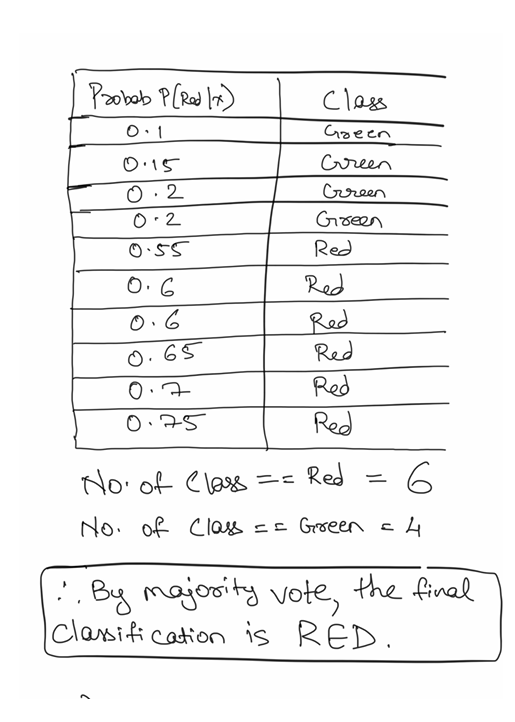
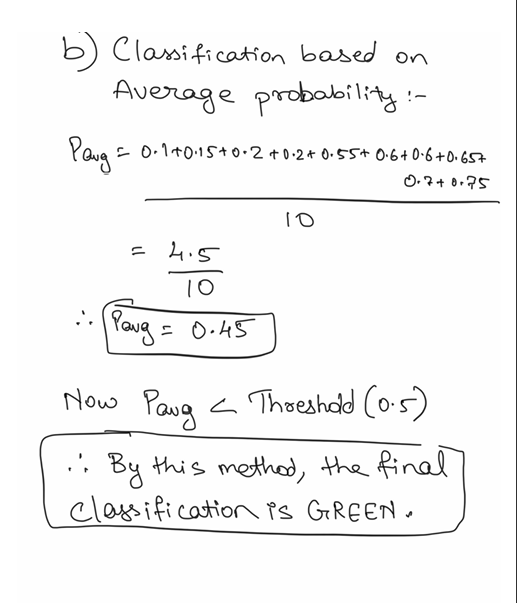

## 5. ISLR 9.7.3

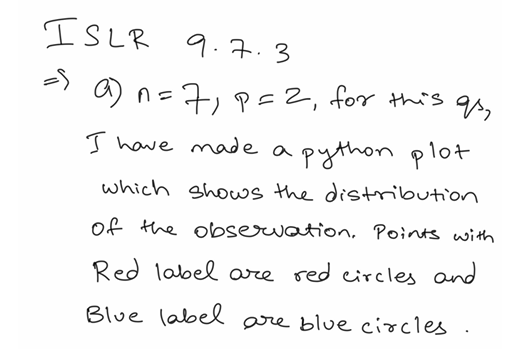

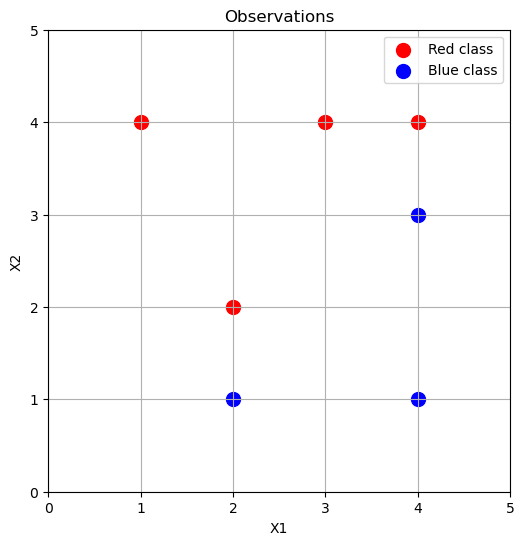

In [36]:
X = np.array([[3,4],[2,2],[4,4],[1,4],[2,1],[4,3],[4,1]])
y_labels = np.array(['Red','Red','Red','Red','Blue','Blue','Blue'])

reds = X[y_labels == 'Red']
blues = X[y_labels == 'Blue']

plt.figure(figsize=(6,6))
plt.scatter(reds[:,0], reds[:,1], c='red', marker='o', s=100, label='Red class')
plt.scatter(blues[:,0], blues[:,1], c='blue', marker='o', s=100, label='Blue class')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Observations")
plt.legend()
plt.grid(True)
plt.xlim(0,5)
plt.ylim(0,5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


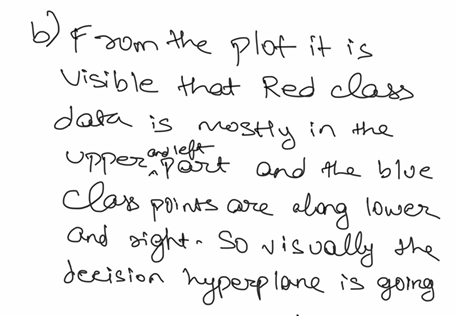
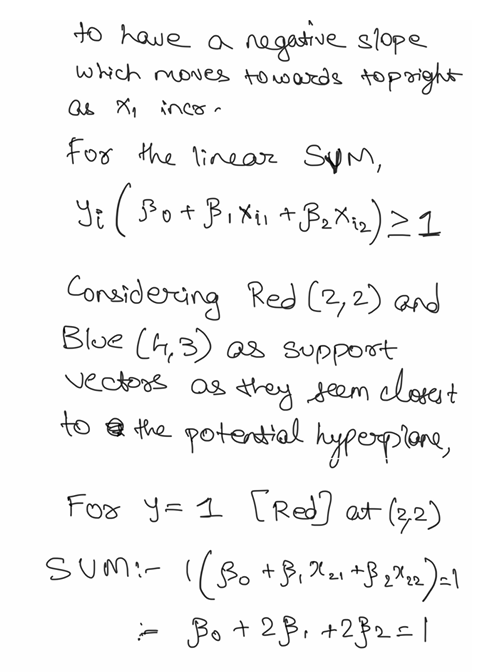
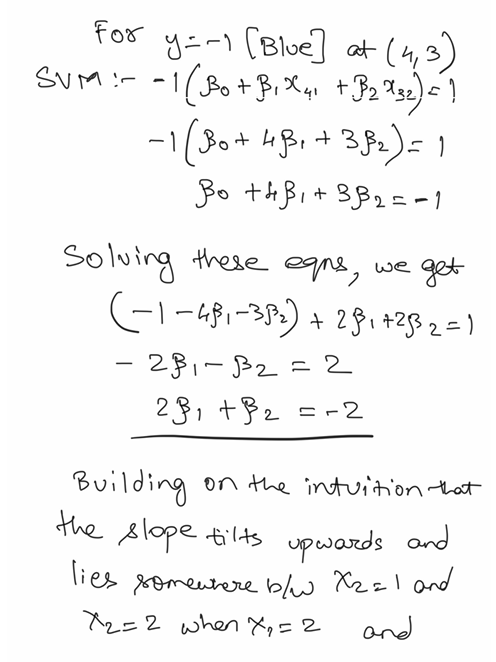
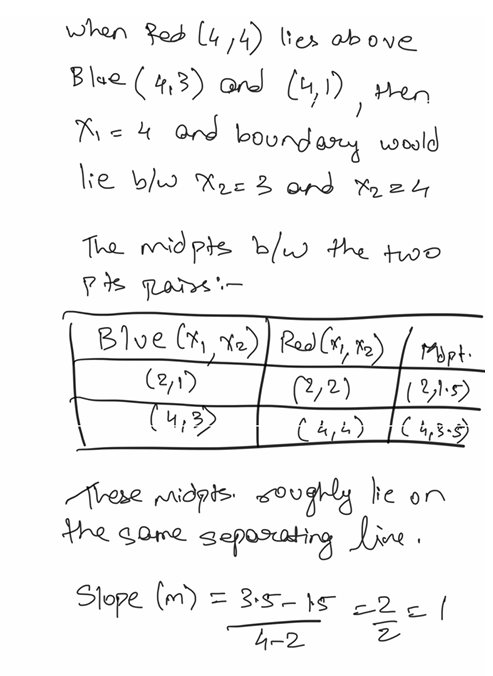
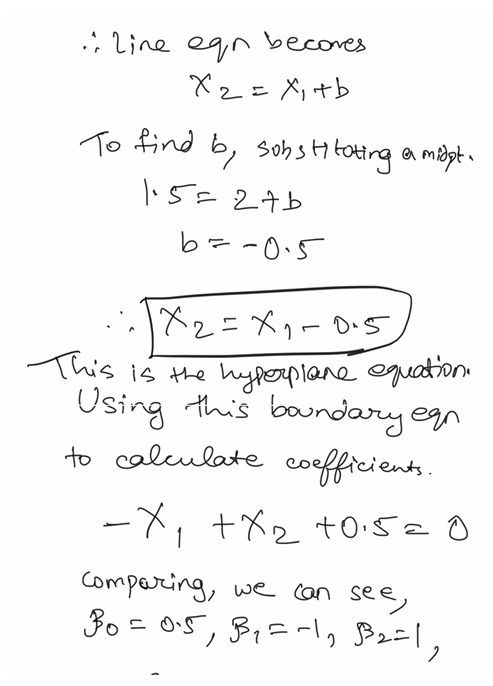
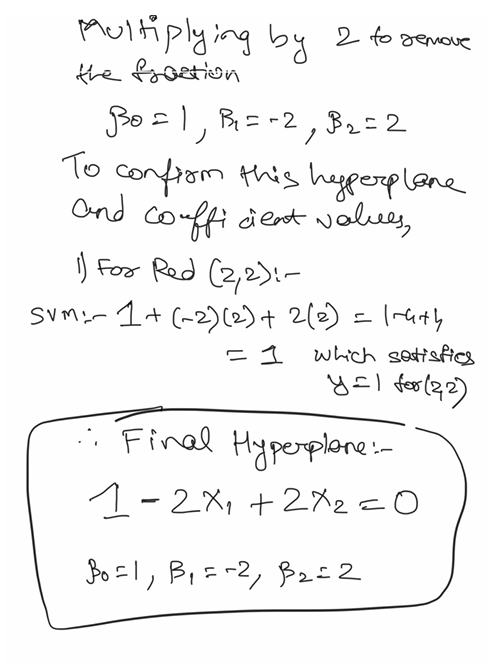

Equation of the optimal separating hyperplane:
1.000 + (-1.999)*X1 + (1.999)*X2 = 0


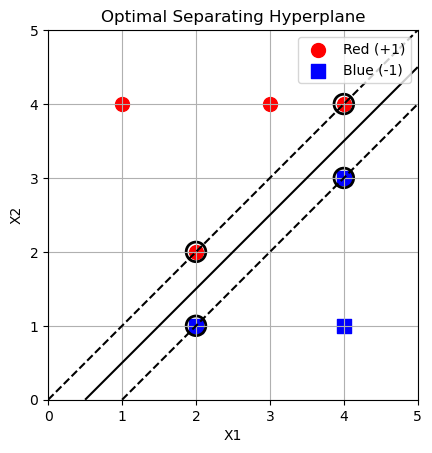

In [37]:
y = np.array([1, 1, 1, 1, -1, -1, -1])

model = SVC(kernel='linear', C=1e6)
model.fit(X, y)

w = model.coef_[0]
b = model.intercept_[0]

print("Equation of the optimal separating hyperplane:")
print(f"{b:.3f} + ({w[0]:.3f})*X1 + ({w[1]:.3f})*X2 = 0")

xx = np.linspace(0, 5, 200)
yy = np.linspace(0, 5, 200)
XX, YY = np.meshgrid(xx, yy)
ZZ = (w[0]*XX + w[1]*YY + b)

plt.scatter(X[y==1, 0], X[y==1, 1], c='red', marker='o', s=100, label='Red (+1)')
plt.scatter(X[y==-1, 0], X[y==-1, 1], c='blue', marker='s', s=100, label='Blue (-1)')

plt.contour(XX, YY, ZZ, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
plt.title("Optimal Separating Hyperplane")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)

plt.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1],
            s=200, facecolors='none', edgecolors='k', linewidths=2, label='Support Vectors')

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


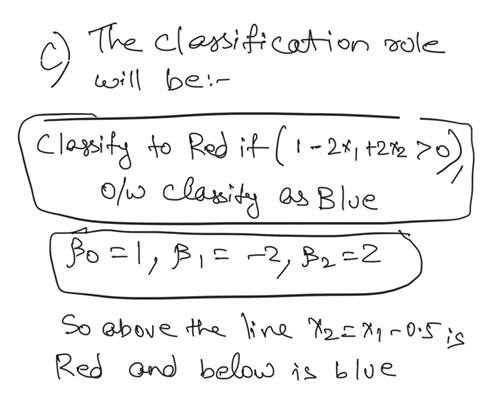

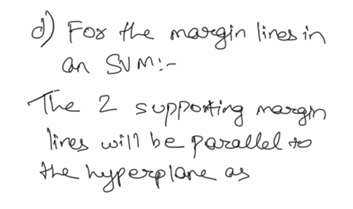
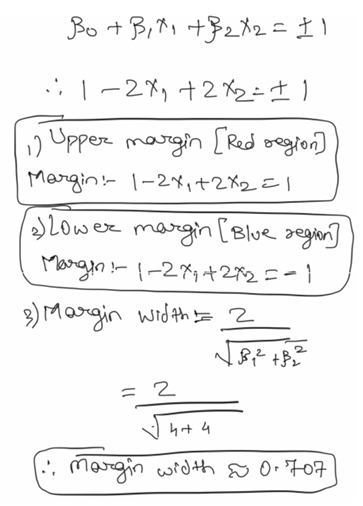

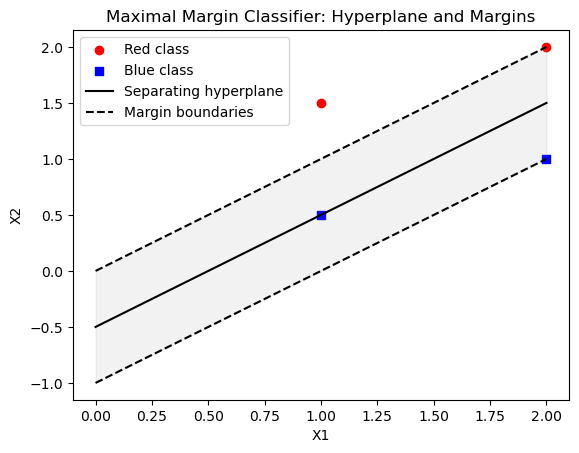

In [38]:
x1 = np.linspace(0, 2, 100)

x2_main = x1 - 0.5         
x2_upper = x1              
x2_lower = x1 - 1           

# Plot points
plt.scatter([1, 2], [1.5, 2], color='red', marker='o', label='Red class')
plt.scatter([1, 2], [0.5, 1], color='blue', marker='s', label='Blue class')

# Plot the hyperplane and margins
plt.plot(x1, x2_main, 'k-', label='Separating hyperplane')
plt.plot(x1, x2_upper, 'k--', label='Margin boundaries')
plt.plot(x1, x2_lower, 'k--')

plt.fill_between(x1, x2_upper, x2_lower, color='gray', alpha=0.1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Maximal Margin Classifier: Hyperplane and Margins')
plt.show()


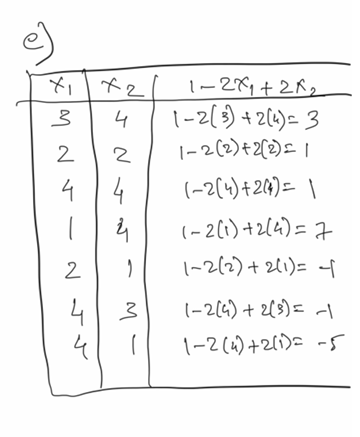
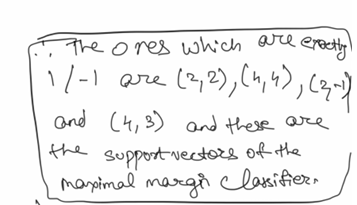

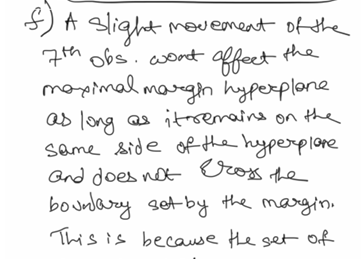
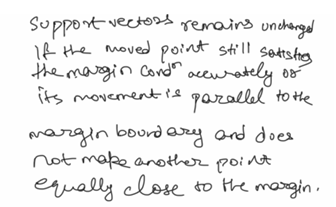

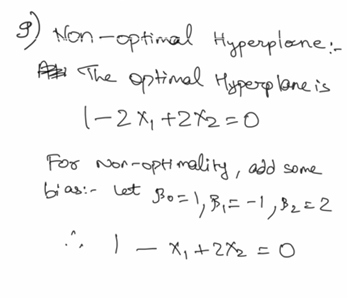
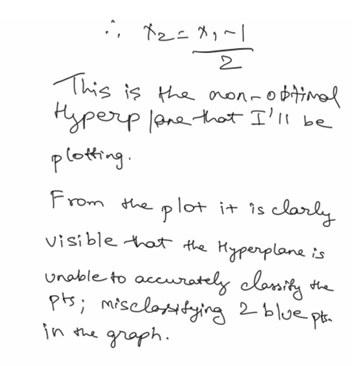

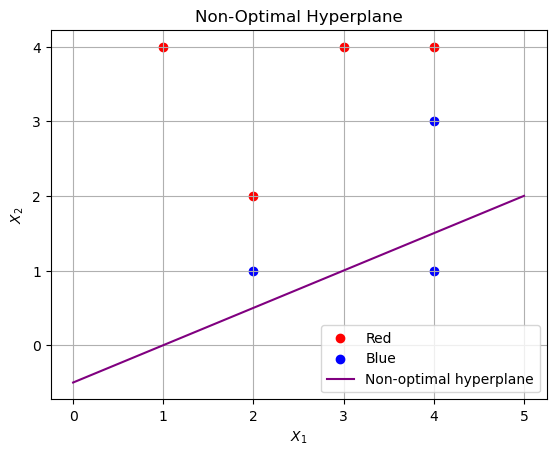

In [39]:
# Plot points
for label, color in [('Red', 'red'), ('Blue', 'blue')]:
    subset = X[y_labels == label]
    plt.scatter(subset[:, 0], subset[:, 1], c=color, label=label)

# Range for hyperplanes
x_vals = np.linspace(0, 5, 100)

# Non-optimal hyperplane: 1 - X1 + 2*X2 = 0 -> X2 = (X1 - 1)/2
plt.plot(x_vals, (x_vals - 1)/2, 'purple', label='Non-optimal hyperplane')

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.title('Non-Optimal Hyperplane')
plt.grid(True)
plt.show()


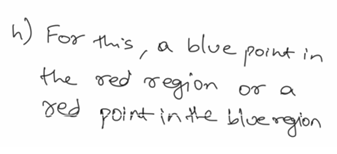
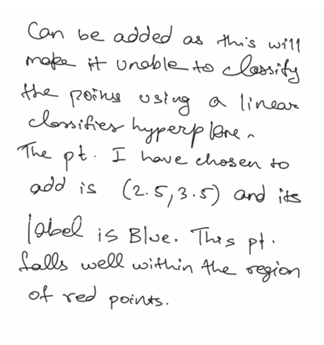

Misclassified indices: [1 7]
Misclassified observations:
Point [2. 2.] true label: Red, predicted: Blue
Point [2.5 3.5] true label: Blue, predicted: Red


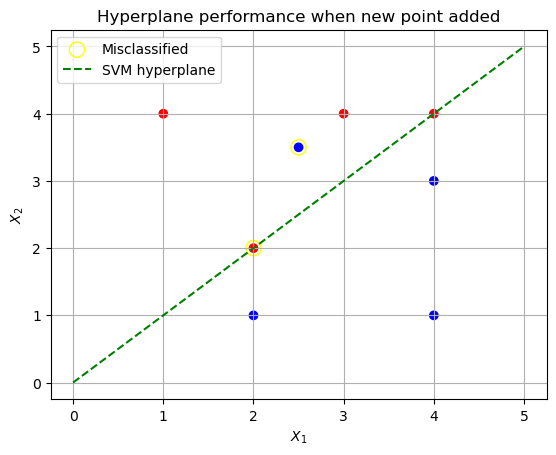

In [40]:
X = np.array([
    [3, 4], [2, 2], [4, 4], [1, 4], [2, 1], [4, 3], [4, 1], [2.5, 3.5]
])
y_labels = np.array(['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue', 'Blue'])
y = np.where(y_labels == 'Red', 1, -1)

clf = SVC(kernel='linear', C=1e6)
clf.fit(X, y)

y_pred = clf.predict(X)

misclassified = np.where(y_pred != y)[0]
print("Misclassified indices:", misclassified)
print("Misclassified observations:")
for idx in misclassified:
    print(f"Point {X[idx]} true label: {y_labels[idx]}, predicted: {'Red' if y_pred[idx]==1 else 'Blue'}")

y_colors = np.where(y_labels == 'Red', 'red', 'blue')
plt.scatter(X[:, 0], X[:, 1], c=y_colors)
plt.scatter(X[misclassified][:, 0], X[misclassified][:, 1], 
            facecolors='none', edgecolors='yellow', s=120, label='Misclassified')

def plot_hyperplane(clf, xmin, xmax, style, label):
    w = clf.coef_[0]
    b = clf.intercept_[0]
    x_vals = np.linspace(xmin, xmax, 100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    plt.plot(x_vals, y_vals, style, label=label)

plot_hyperplane(clf, 0, 5, 'g--', 'SVM hyperplane')

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend()
plt.title('Hyperplane performance when new point added')
plt.grid(True)
plt.show()


https://medium.com/@ajayverma23/data-imputation-a-comprehensive-guide-to-handling-missing-values-b5c7d11c3488


https://medium.com/@fadleemt/balanced-random-forest-d5dc9c896bb4